Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [8]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning  # 수정된 부분
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

In [10]:
import matplotlib.pyplot as plt


def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family


font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)

# Chapter 10 - Monte Carlo Simulations in Finance

Monte Carlo 시뮬레이션은 반복적인 무작위 샘플링을 사용하여 확률적으로 해석될 수 있는 문제를 해결하는 일련의 계산 알고리즘입니다. 금융 분야에서 Monte Carlo 시뮬레이션이 인기를 끌게 된 이유 중 하나는 적분을 정확하게 추정하는 데 사용할 수 있기 때문입니다. Monte Carlo 시뮬레이션의 주요 아이디어는 샘플 경로(가능한 시나리오/결과)의 다수를 생성하는 것입니다. 이 경로는 지정된 시간 단계 수로 나뉘며, 이를 통해 연속 시간을 근사화합니다. 이 과정을 이산화라고 하며, 그 목표는 금융 상품 가격 결정이 일어나는 연속적인 시간을 근사하는 것입니다.

이 모든 시뮬레이션 샘플 경로에서 나온 결과는 사건이 발생한 비율, 마지막 단계에서 금융 상품의 평균 가치 등을 계산하는 데 사용할 수 있습니다. 역사적으로 Monte Carlo 방법의 주요 문제는 이러한 계산에 많은 컴퓨팅 파워가 필요하다는 점이었습니다. 하지만 현재는 데스크탑 컴퓨터나 노트북에서도 상당히 고급 시뮬레이션을 실행할 수 있으며, 컴퓨팅 파워가 부족할 경우 클라우드 컴퓨팅과 같은 강력한 프로세서를 사용할 수 있습니다.

이 장을 끝낼 무렵에는 다양한 시나리오와 작업에서 Monte Carlo 방법을 사용하는 방법을 알게 될 것입니다. 일부는 처음부터 직접 시뮬레이션을 작성하고, 다른 경우에는 현대적인 Python 라이브러리를 사용하여 과정을 더욱 쉽게 만들 것입니다. Monte Carlo 방법의 유연성 덕분에, 이 방법은 다양한 문제에 적용할 수 있습니다. 예를 들어 폐쇄형 솔루션이 없는 파생상품(미국/이국적인 옵션) 가격 책정, 포트폴리오의 불확실성(예: VaR(Value-at-Risk) 및 ES(Expected Shortfall)) 추정, 그리고 리스크 관리에서 스트레스 테스트를 수행하는 것 등이 있습니다. 이 장에서는 이러한 문제들 중 일부를 해결하는 방법을 보여줄 것입니다.

이 장에서 다루는 내용은 다음과 같습니다:

- 기하학적 Brownian 운동을 사용하여 주식 가격 역학 시뮬레이션
- 시뮬레이션을 사용하여 유럽식 옵션 가격 책정
- Least Squares Monte Carlo를 사용하여 미국식 옵션 가격 책정
- QuantLib을 사용하여 미국식 옵션 가격 책정
- 장벽 옵션 가격 책정
- Monte Carlo를 사용하여 VaR(Value-at-Risk) 추정

## 10.1 Simulating stock price dynamics using geometric Brownian motion

**기하학적 Brownian 운동을 사용하여 주식 가격 역학 시뮬레이션**

주식 가격 시뮬레이션은 특히 옵션을 포함한 많은 파생 상품의 평가에서 중요한 역할을 합니다. 이러한 시뮬레이션은 가격 움직임의 무작위성 때문에 확률 미분 방정식(SDE)에 의존합니다. 확률 과정이 다음의 기하학적 Brownian 운동(GBM)을 따를 때, 이는 다음의 SDE를 만족합니다:

$
dS_t = \mu S_t dt + \sigma S_t dW_t
$

여기서, 우리는 다음을 갖습니다:

- $S_t$: 주가
- $\mu$: 드리프트 계수, 즉, 주어진 기간 동안의 평균 수익률 또는 순간 기대 수익률
- $\sigma$: 확산 계수, 즉, 드리프트에서 얼마나 많은 변동성이 있는지를 나타냅니다.
- $W_t$: Brownian 운동
- $d$: 고려된 시간 증가에 따라 변수의 변화

우리는 Brownian 운동의 성질을 깊이 탐구하지는 않을 것입니다. 이는 이 책의 범위를 벗어나기 때문입니다. 간단히 말해, Brownian 증가는 표준 정규 난수 ($rv \sim N(0, 1)$와 시간 증가의 제곱근의 곱으로 계산됩니다. 우리는 Brownian 증가의 누적 합계를 취하여 Brownian 경로를 얻습니다.

위에서 언급한 SDE는 폐쇄형 솔루션을 갖는 몇 안 되는 방정식 중 하나입니다:

$
S(t) = S_0 e^{\left(\mu - \frac{1}{2} \sigma^2\right) t + \sigma W_t}
$

여기서 $S_0 = S(0)$는 이 과정의 초기 값이며, 이 경우 초기 주가입니다. 이 방정식은 시간 $t$에서의 주가와 초기 주가 사이의 관계를 나타냅니다.

시뮬레이션을 위해 우리는 다음의 재귀 공식을 사용할 수 있습니다:

$
S(t_{i+1}) = S(t_i) \exp \left(\left(\mu - \frac{1}{2} \sigma^2 \right) (t_{i+1} - t_i) + \sigma \sqrt{t_{i+1} - t_i} Z_{i+1} \right)
$

여기서 $Z_i$는 표준 정규 난수이며 $i = 0, 1, \dots, T-1$는 시간 지수를 나타냅니다. 이 명세는 $W$의 증가가 독립적이고 정규 분포임을 전제로 합니다. 이 공식을 더 잘 이해하기 위해서는 Euler의 이산화 방법을 참고하시기 바랍니다.

GBM은 평균 복귀 및 시간 의존 변동성을 고려하지 않기 때문에 채권 가격보다는 주식 가격을 시뮬레이션하는 데 자주 사용됩니다. 채권 가격은 장기적으로 명목가로의 복귀 경향을 보이기 때문입니다.

이 절에서는 Monte Carlo 방법과 GBM을 사용하여 2021년 데이터를 기반으로 2022년 1월 동안 IBM 주식 가격의 한 달 후 경로를 시뮬레이션합니다.

### How to do it...

1. Import the libraries:

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf

2. Download data from Yahoo Finance:

In [13]:
df = yf.download("IBM", 
                 start="2021-01-01", 
                 end="2022-01-31",)
                #  adjusted=True)

[*********************100%***********************]  1 of 1 completed


3. Calculate and plot daily returns:

**Step 2와 3에서**, 우리는 IBM의 주식 가격을 다운로드하고 간단한 수익률을 계산합니다. 

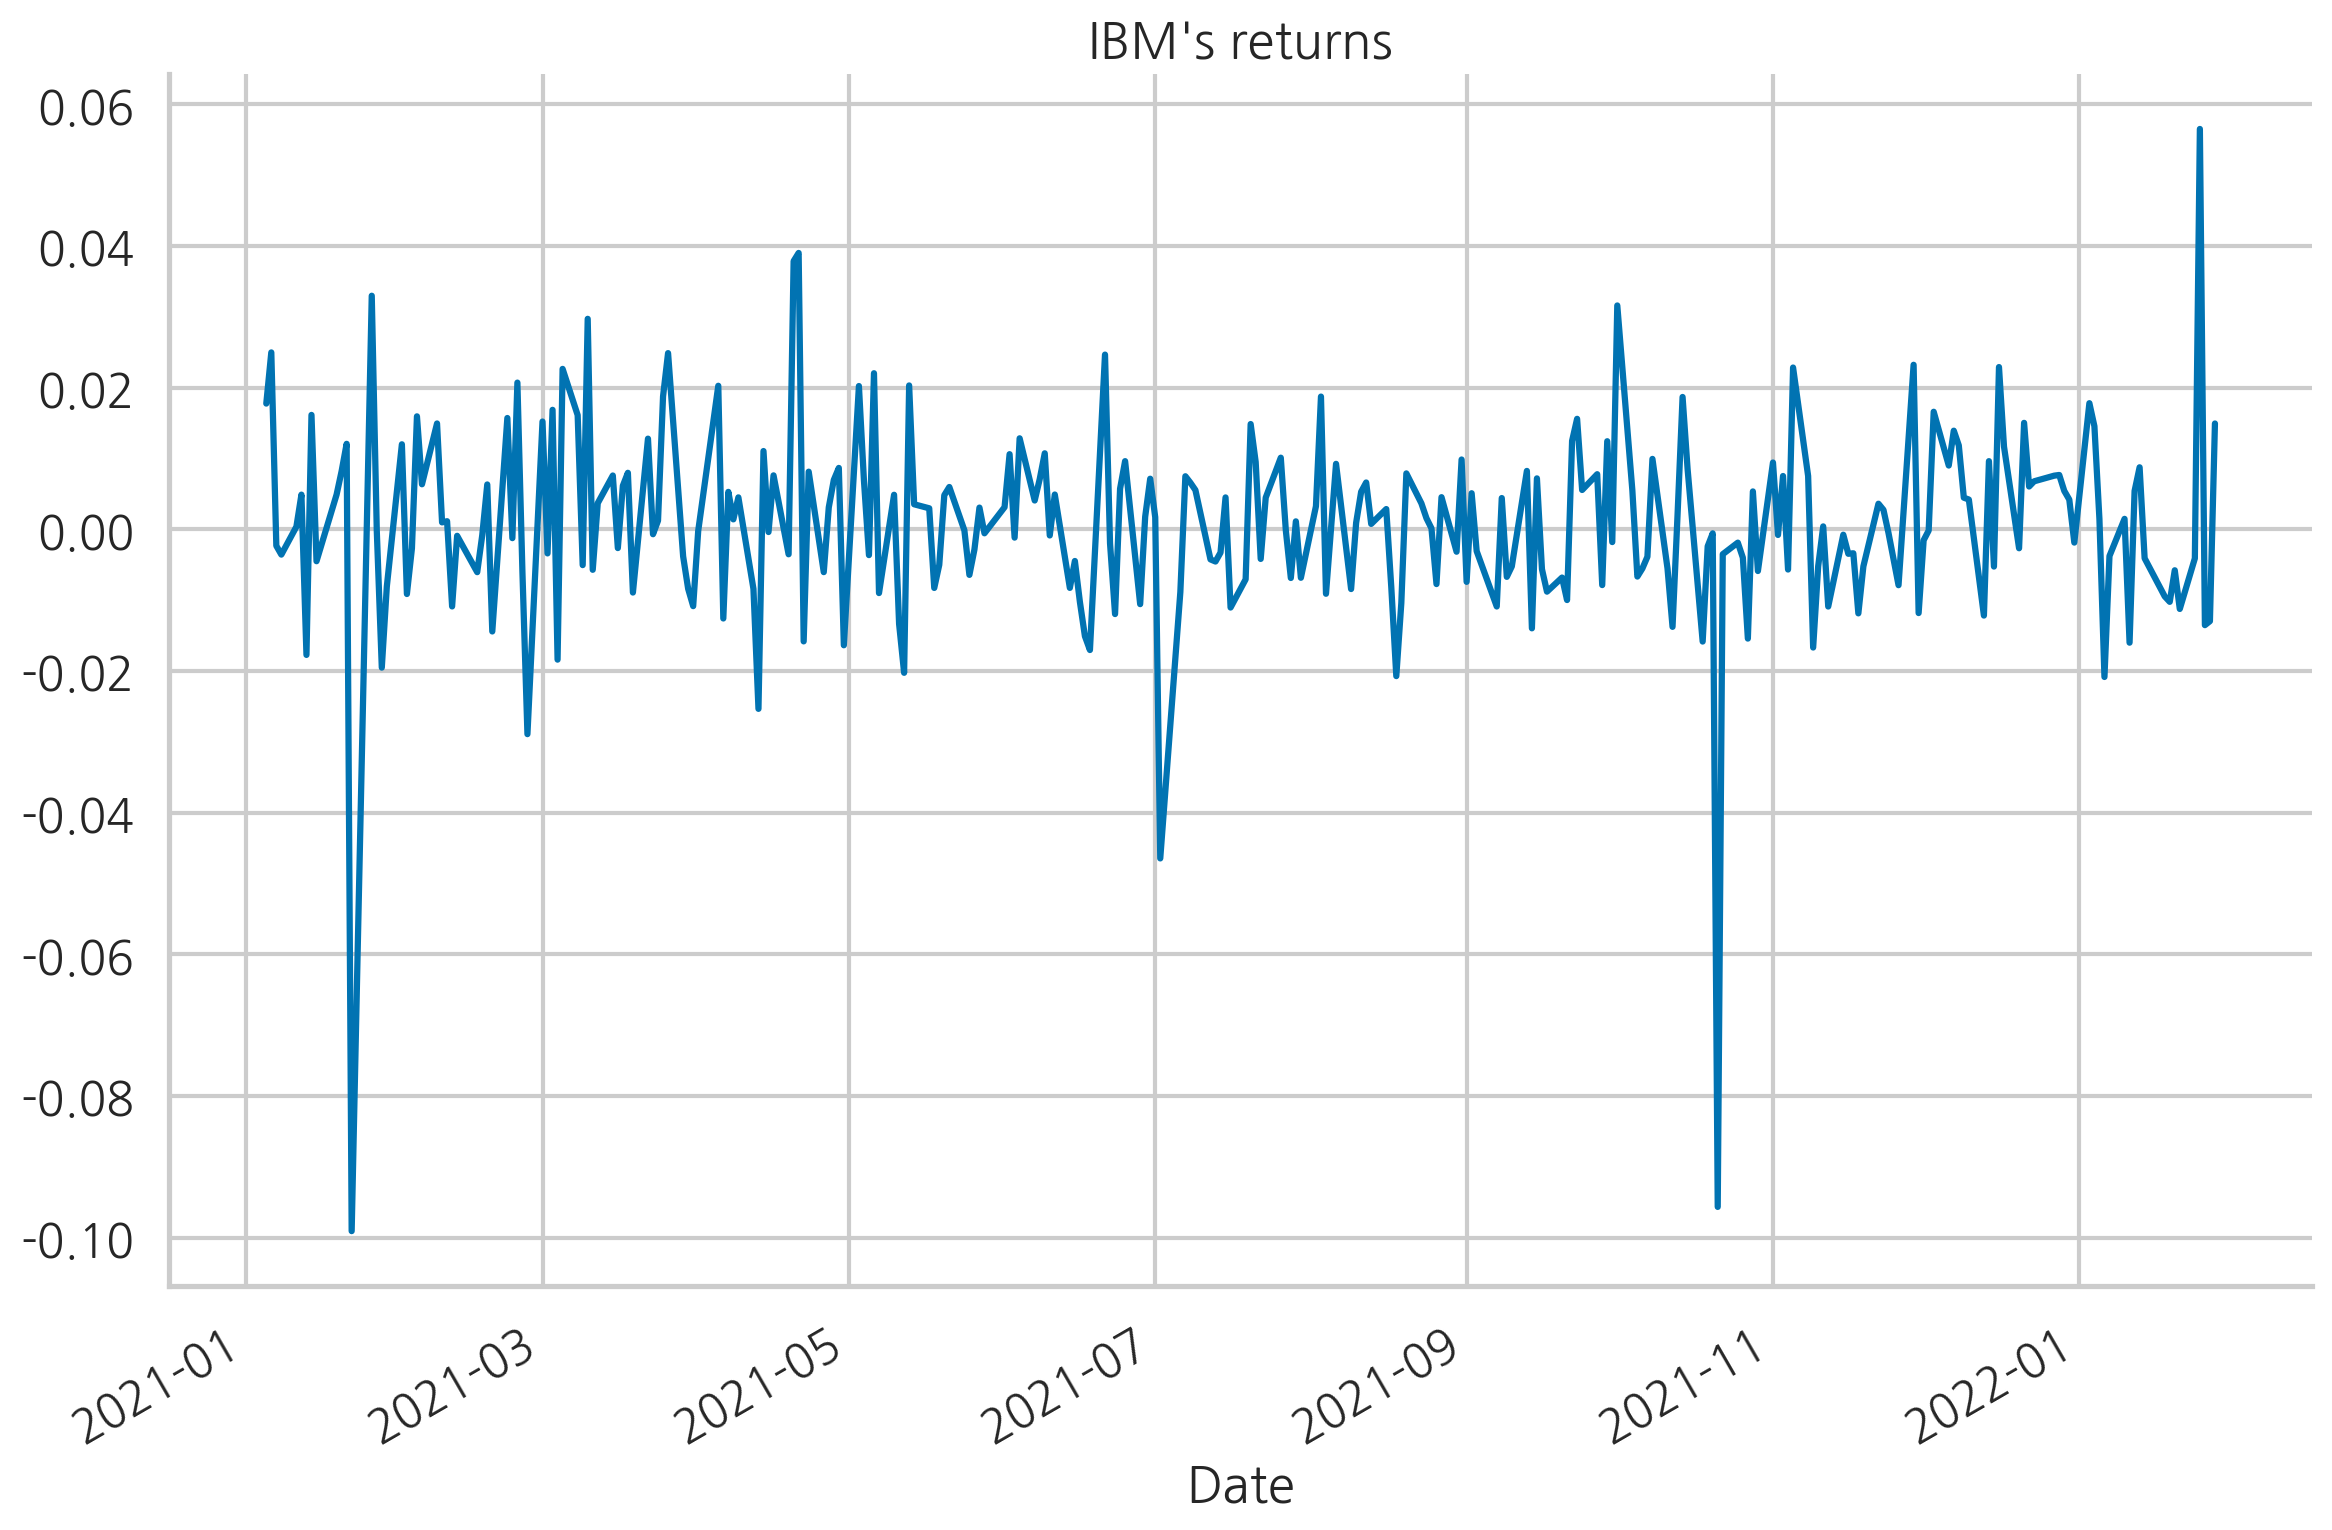

In [14]:
returns = df["Adj Close"].pct_change().dropna()
returns.plot(title="IBM's returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_1", dpi=200)

In [15]:
print(f"Average return: {100 * returns.mean():.2f}%")

Average return: 0.08%


4. Split data into the training and test sets:

다음 단계에서, 데이터를 학습 세트와 테스트 세트로 나눕니다. 여기서는 명시적인 모델 학습이 없지만, 학습 세트를 사용하여 재귀 변환의 평균 및 표준 편차를 계산합니다. 그리고 이러한 값을 사용하여 시뮬레이션에 필요한 드리프트($\mu$)와 확산($\sigma$) 계수를 계산합니다. 

In [16]:
train = returns["2021"]
test = returns["2022"]

5. Specify the parameters of the simulation:

또한, **Step 5에서** 다음의 매개변수를 정의합니다:

- **T**: 예측 수평선; 이 경우 테스트 세트에서의 일 수.
- **N**: 예측 수평선에서의 시간 증가 수. 시뮬레이션에서는 $N = T$로 유지합니다.
- **S_0**: 초기 가격. 이 시뮬레이션에서는 학습 세트에서 가져온 초기 값을 사용합니다.
- **N_SIM**: 시뮬레이션된 경로 수.

Monte Carlo 시뮬레이션은 이산화라는 과정을 사용합니다. 이 아이디어는 금융 자산의 연속적인 가격 책정을 많은 수의 이산 간격으로 나누어 근사하는 것입니다. 그래서 예측 수평선을 고려할 때, 시간 증가 수를 맞추기 위해서도 필요합니다.

In [17]:
T = len(test)
N = len(test)
S_0 = df.loc[train.index[-1], "Adj Close"]
N_SIM = 100
mu = train.mean()
sigma = train.std()

6. Define the function used for simulations:

**Step 6에서**, 우리는 시뮬레이션을 실행하기 위한 함수를 정의합니다. 이러한 문제에 대해 함수를/클래스를 정의하는 것은 좋은 습관입니다. 이는 다음 레시피에서도 유용할 것입니다. 이 함수는 다음 단계들을 실행합니다:

1. 시간 증가($dt$)와 Brownian 증가($dW$)를 정의합니다.
2. Brownian 경로($W$)를 행의 누적 합계로 계산합니다($np.cumsum$).
3. 시간 단계($time\_steps$)를 포함하는 행렬을 생성합니다. 이를 위해, 시뮬레이션의 수평선 내에서 간격이 균일한 배열을 생성합니다. 그런 다음 $np.linspace$ 함수를 사용합니다. 이후 배열을 원하는 모양으로 방송합니다($np.broadcast\_to$).
4. 닫힌 형식의 공식을 사용하여 각 시간 지점에서 주식을 계산합니다.
5. 초기 값을 각 행의 첫 번째 위치에 삽입합니다.

벡터에 시간 단계를 방송할 명시적인 필요는 없습니다. 이는 자동으로 이루어지기 때문입니다. 코드를 더 쉽게 디버깅할 수 있게 해줍니다. 우리는 또한 R과 같은 언어에서는 자동 브로드캐스팅이 없다는 점을 인지해야 합니다.

함수 정의에서, 우리는 드리프트를 $(\mu - 0.5 * \sigma^2) * time\_steps$로, 확산을 $\sigma * W$로 인식할 수 있습니다. 또한 큰 시뮬레이션에서 벡터화된 접근 방식을 따릅니다. 이를 통해 $for$ 루프 작성을 피할 수 있으며, 이는 비효율적일 수 있습니다.


In [19]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    """
    기하 브라운 운동을 사용하여 주식 수익률을 시뮬레이션하는 함수입니다.
    
    매개변수
    ------------
    s_0 : float
        초기 주가
    mu : float
        드리프트 계수 (평균 수익률)
    sigma : float
        변동성 계수 (표준편차)
    n_sims : int
        시뮬레이션 경로의 수
    T : float
        예측 기간의 길이 (단위: 일)
    N : int
        예측 기간 내 시간 증분의 수
    random_seed : int
        재현성을 위한 랜덤 시드

    반환값
    -----------
    S_t : np.ndarray
        시뮬레이션 결과를 포함하는 행렬 (크기: n_sims x (T+1)). 
        행은 샘플 경로를, 열은 시간 지점을 나타냅니다.
    """
    # 랜덤 시드 설정
    np.random.seed(random_seed)
    
    # 시간 증분 계산
    dt = T/N
    # 브라운 운동의 증분 생성
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N))
    # 브라운 운동 경로 계산
    W = np.cumsum(dW, axis=1)
    
    # 시간 단계 생성
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    # 기하 브라운 운동 공식을 사용하여 주가 시뮬레이션
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)
    # 초기 주가를 첫 번째 열에 삽입
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

7. Run the simulations and store the results in a DataFrame:

**Step 7에서**, 우리는 시뮬레이션을 실행하고 그 결과(샘플 경로)를 DataFrame에 저장합니다. 이 작업을 수행하는 동안, 각 열에 하나의 경로만 있게 하여 데이터를 전치합니다. 이는 $pandas$ DataFrame의 $plot$ 메서드를 사용하는 데 있어 더 간단하게 해줍니다. 적절한 인덱스를 갖기 위해, 우리는 학습 세트의 마지막 관측값의 인덱스와 테스트 세트의 인덱스를 결합하기 위해 $union$ 메서드를 사용합니다.

In [20]:
# 기하 브라운 운동 시뮬레이션 실행
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

# 시뮬레이션 결과를 DataFrame으로 변환
# np.transpose()를 사용하여 각 열이 하나의 시뮬레이션 경로를 나타내도록 함
# index는 훈련 세트의 마지막 날짜와 테스트 세트의 모든 날짜를 포함하도록 설정
sim_df = pd.DataFrame(np.transpose(gbm_simulations), 
                      index=train.index[-1:].union(test.index))

8. Create a DataFrame with the average value for each time step and the corresponding actual stock price:

**Step 8에서**, 우리는 각 시간 지점에서 시뮬레이션된 모든 경로의 평균값으로 예측 주가를 계산하고, 이 결과를 DataFrame에 저장합니다. 그런 다음 해당 날짜에 대한 실제 주가와 결합합니다.

In [21]:
# 시뮬레이션 결과의 평균값 계산
res_df = sim_df.mean(axis=1).to_frame()

# 실제 주가 데이터와 결합
res_df = res_df.join(df["Adj Close"])

# 열 이름 설정
res_df.columns = ["simulation_average", "adj_close_price"]

# 결과 확인 (상위 5개 행 출력)
res_df.head()

# 위 코드는 다음과 같은 작업을 수행합니다:
# 1. 시뮬레이션된 모든 경로의 평균값을 계산합니다.
# 2. 실제 주가 데이터를 시뮬레이션 결과와 결합합니다.
# 3. 열 이름을 의미 있게 설정합니다.
# 4. 결과의 처음 5개 행을 출력하여 데이터를 확인합니다.

,simulation_average,adj_close_price
Date,,
2021-12-31,118.009171,118.009171
2022-01-03,118.248317,120.110481
2022-01-04,118.443603,121.858643
2022-01-05,118.537857,122.035217
2022-01-06,118.884066,119.492424


9. Plot the results of the simulation:

마지막 단계에서는, 시뮬레이션된 경로를 시각화합니다. 경로를 시각화할 때, 투명성을 위해 $alpha=0.3$을 선택하여 두 개의 선(예측된 평균 경로와 실제 경로)을 더 쉽게 볼 수 있도록 합니다.

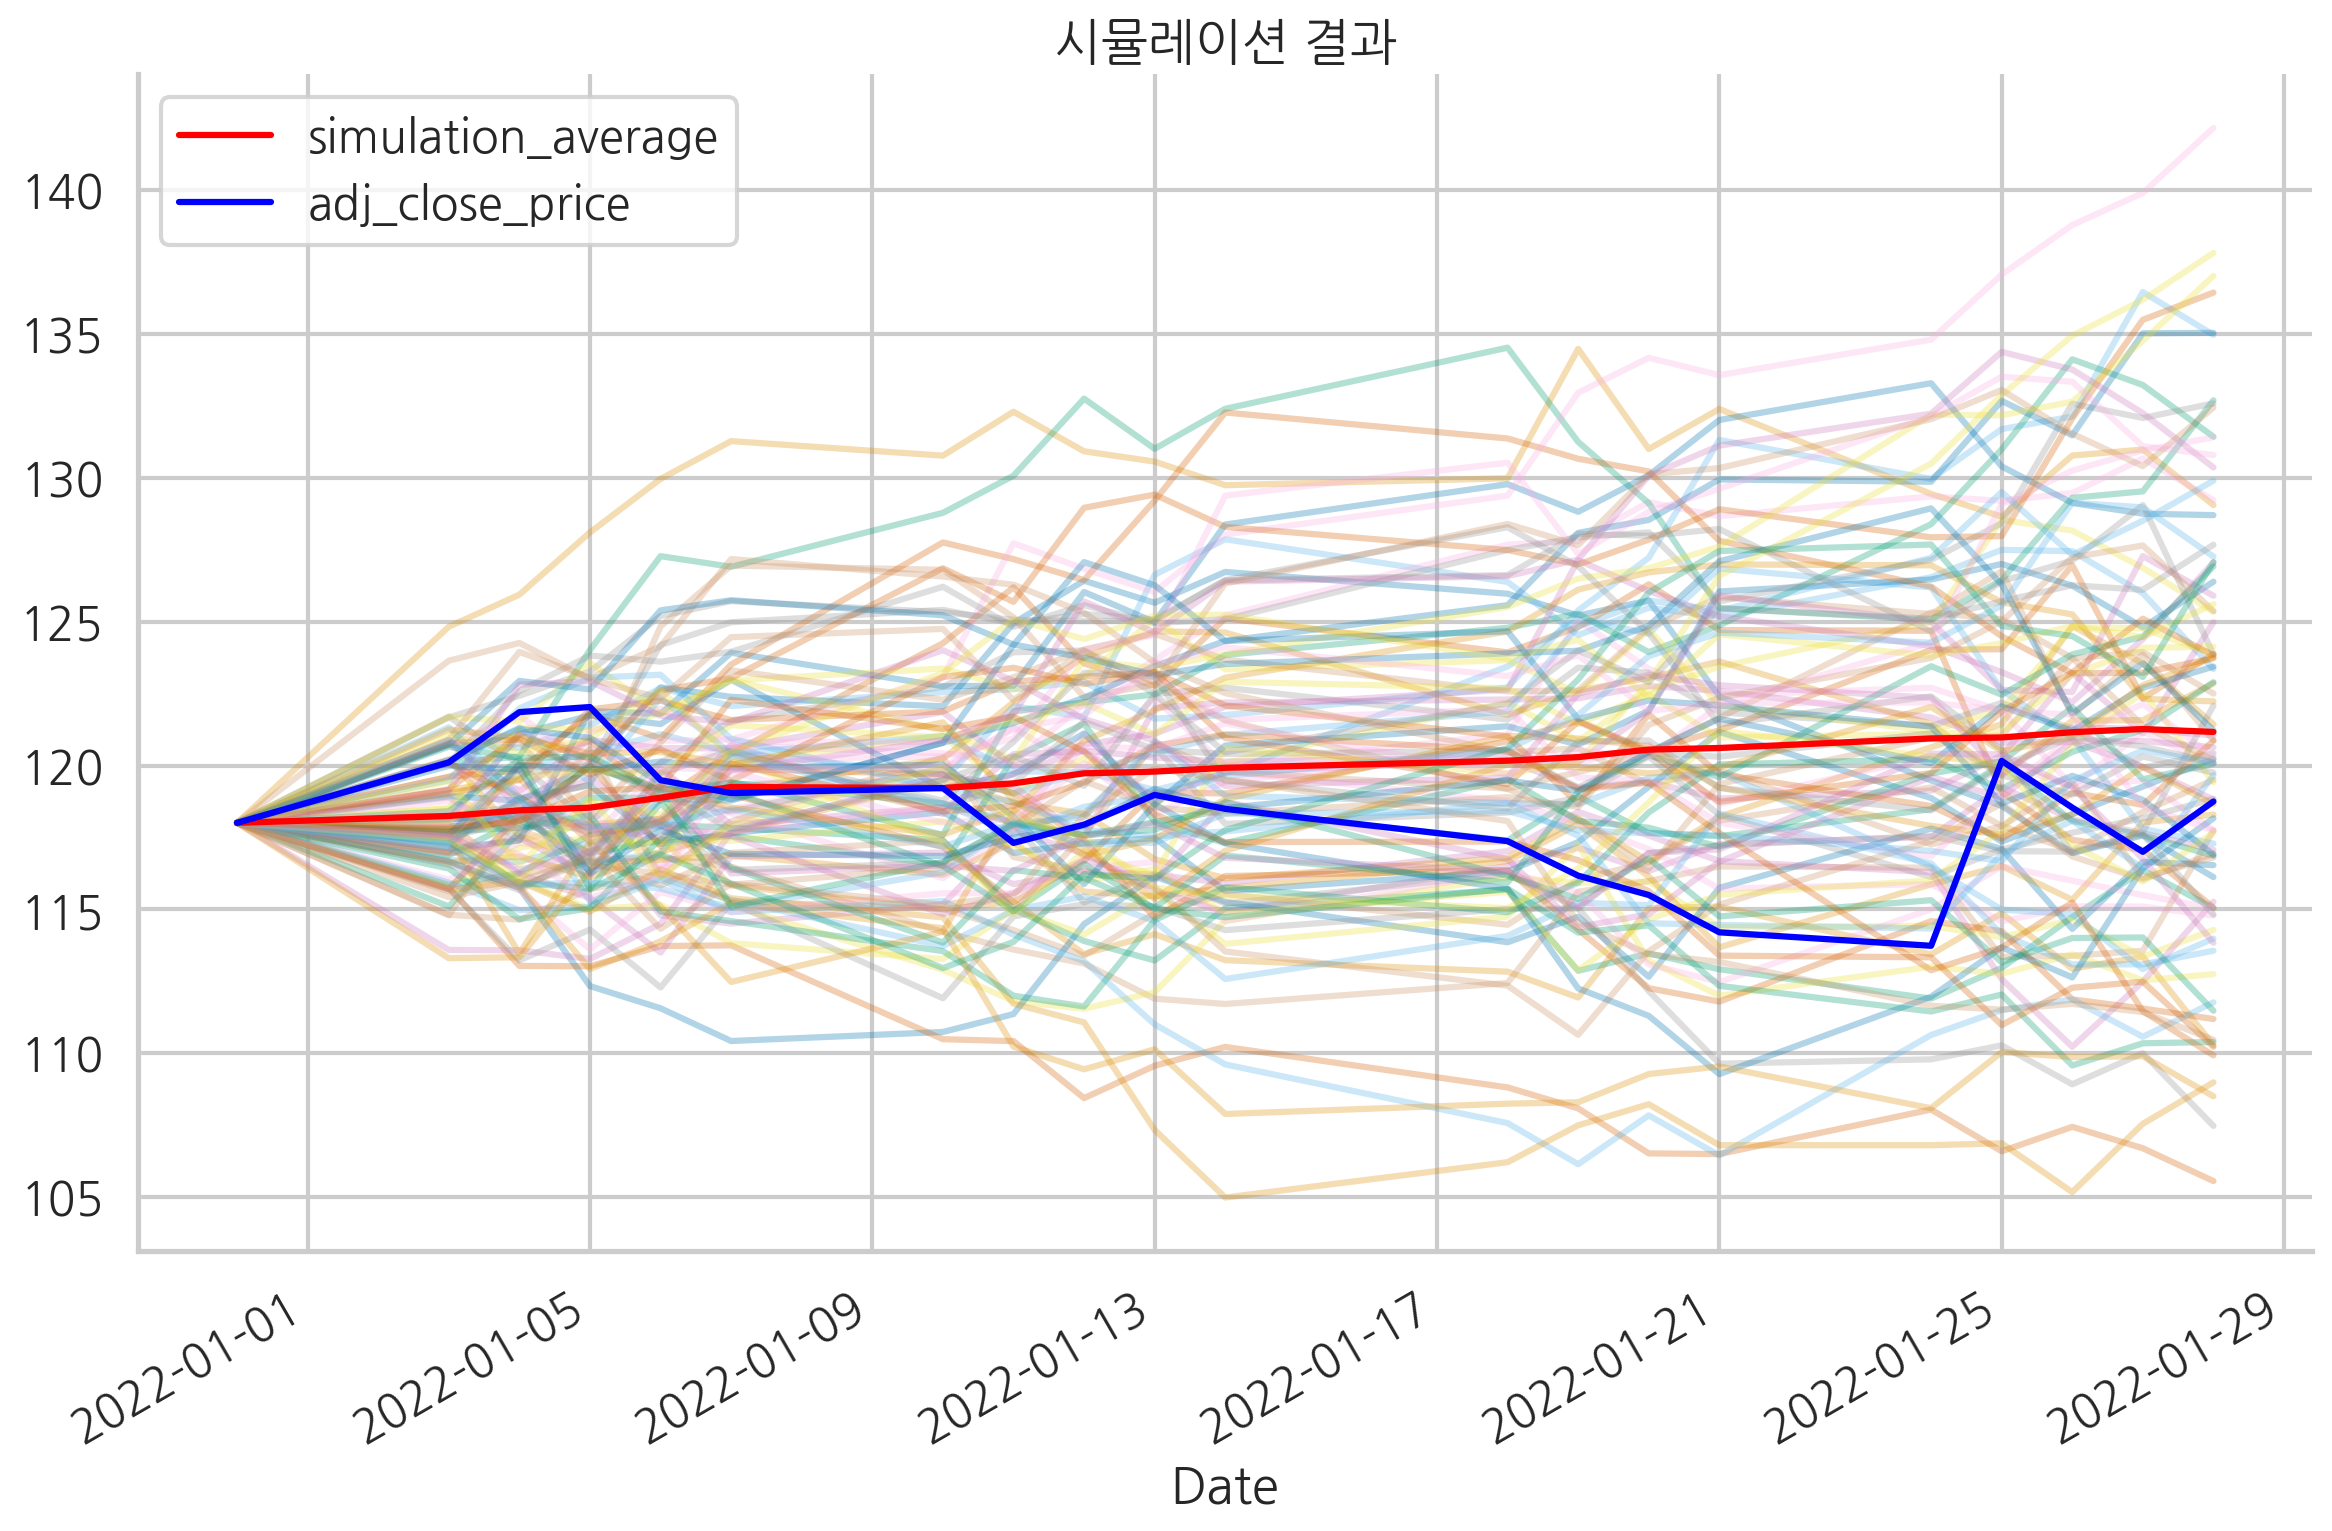

In [22]:
# 시뮬레이션 결과를 시각화합니다
ax = sim_df.plot(
    alpha=0.3,  # 투명도를 0.3으로 설정하여 여러 경로를 겹쳐 표시
    legend=False,  # 범례를 표시하지 않음
    title="시뮬레이션 결과"  # 그래프 제목 설정
)

# 실제 주가와 시뮬레이션 평균을 추가로 플롯
res_df.plot(ax=ax, color = ["red", "blue"])  # 빨간색: 시뮬레이션 평균, 파란색: 실제 주가

# 그래프 스타일 조정
sns.despine()  # 상단과 우측 테두리 제거
plt.tight_layout()  # 그래프 레이아웃 최적화

# 그래프를 이미지 파일로 저장 (현재는 주석 처리됨)
# plt.savefig("images/figure_10_2", dpi=200)

### There's more 


Monte Carlo 시뮬레이션을 더 쉽게 만드는 몇 가지 통계적 방법들이 있습니다(더 높은 정확도, 빠른 계산 속도). 그 중 하나는 **대칭 변수(Antithetic Variates)** 라고 불리는 분산 감소 방법입니다. 이 접근법에서는 추정기의 분산을 줄이기 위해 무작위 추출 쌍 사이에 음의 상관성을 도입하려고 합니다. 이는 다음과 같이 나타납니다: 샘플 경로를 생성할 때, 각 $\epsilon_1, \dots, \epsilon_t$에 대해 반대 부호의 값들, 즉 $-\epsilon_1, \dots, -\epsilon_t$를 함께 사용합니다.

이 접근법의 장점은 다음과 같습니다:

- 경로 $N$을 생성하는 데 필요한 표준 정규 샘플 수를 절반으로 줄입니다.
- 샘플 경로 분산을 줄이면서 동시에 정확도를 향상시킵니다.

우리는 이 접근법을 향상된 **simulate_gbm** 함수에 구현했습니다. 또한 대부분의 계산을 한 줄에 넣어 함수를 더 간결하게 만들었습니다.

이러한 변경을 구현하기 전에, 우리는 함수의 초기 버전을 측정했습니다:

In [23]:
# simulate_gbm 함수의 실행 시간을 측정합니다
# %timeit 매직 명령어를 사용하여 함수 실행 시간의 평균과 표준편차를 계산합니다
# 이는 함수의 성능을 평가하는 데 유용합니다
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

83.5 μs ± 216 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, 
                 antithetic_var=False):
    """
    기하 브라운 운동을 사용하여 주식 수익률을 시뮬레이션하는 함수입니다.
    
    매개변수
    ------------
    s_0 : float
        초기 주가
    mu : float
        드리프트 계수
    sigma : float
        확산 계수
    n_sims : int
        시뮬레이션 경로 수
    T : float
        예측 기간의 길이 (dt와 동일한 단위)
    N : int
        예측 기간의 시간 증분 수
    random_seed : int
        재현성을 위한 랜덤 시드
    antithetic_var : bool
        분산을 줄이기 위해 대칭 변수 접근법을 사용할지 여부

    반환값
    -----------
    S_t : np.ndarray
        시뮬레이션 결과를 포함하는 행렬 (크기: n_sims x (T+1)). 
        행은 샘플 경로를, 열은 시간점을 나타냅니다.
    """
    
    # 랜덤 시드 설정
    np.random.seed(random_seed)
    
    # 시간 증분 계산
    dt = T/N
    
    # 브라운 운동 생성
    if antithetic_var:
        # 대칭 변수 접근법 사용 시
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        # 일반적인 경우
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # 주가 과정의 진화 시뮬레이션
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0  # 초기 주가 설정
    
    return S_t

In [25]:
# simulate_gbm 함수의 실행 시간을 측정합니다
# %timeit 매직 명령어를 사용하여 여러 번 실행하고 평균 시간을 계산합니다
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

# S_0: 초기 주가
# mu: 드리프트 계수
# sigma: 확산 계수
# N_SIM: 시뮬레이션 경로 수
# T: 예측 기간의 길이
# N: 예측 기간의 시간 증분 수

51 μs ± 520 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
# 대칭 변수 접근법을 사용하여 simulate_gbm 함수의 실행 시간을 측정합니다
# antithetic_var=True 옵션을 사용하여 분산 감소 기법을 적용합니다
# %timeit 매직 명령어를 사용하여 여러 번 실행하고 평균 시간을 계산합니다
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

# S_0: 초기 주가
# mu: 드리프트 계수
# sigma: 확산 계수
# N_SIM: 시뮬레이션 경로 수
# T: 예측 기간의 길이
# N: 예측 기간의 시간 증분 수
# antithetic_var=True: 대칭 변수 접근법 사용 (분산 감소를 위해)

36.3 μs ± 163 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### See also

이 레시피에서는 기하학적 Brownian 운동을 사용하여 주식 가격을 시뮬레이션하는 방법을 보여주었습니다. 그러나 다른 확률 과정도 사용할 수 있으며, 그 중 일부는 다음과 같습니다:

- 점프-확산 모델: Merton, R. “Option Pricing When the Underlying Stock Returns Are Discontinuous,” *Journal of Financial Economics*, 3, 3 (1976): 125–144
- 제곱근 확산 모델: Cox, John, Jonathan Ingersoll, and Stephen Ross, “A theory of the term structure of interest rates,” *Econometrica*, 53, 2 (1985): 385–407
- 확률적 변동성 모델: Heston, S. L., “A closed-form solution for options with stochastic volatility with applications to bond and currency options,” *The Review of Financial Studies*, 6(2): 327–343.

## 10.2 Pricing European options using simulations 

**시뮬레이션을 사용한 유럽식 옵션 가격 책정**

옵션은 파생 상품의 일종으로, 그 가격은 기초 자산의 가격(예: 주식)에 연결되어 있습니다. 옵션 계약을 구매하면, 특정 가격(스트라이크라고 함)으로 특정 날짜 이전 또는 그 날짜에 기초 자산을 매매할 권리(의무는 아님)를 얻게 됩니다. 옵션이 인기가 있는 주요 이유는 자산 가격이 바람직하지 않은 방식으로 움직이는 것을 헤지하는 데 사용되기 때문입니다.

이 레시피에서는 한 가지 유형의 옵션, 즉 유럽식 옵션에 중점을 둡니다. 유럽식 콜/풋 옵션은 특정 만기일(일반적으로 $T$로 표시)에서 특정 자산을 매매할 수 있는 권리를 부여합니다.

옵션 평가에는 여러 가지 방법이 있습니다. 예를 들어:

- 해석적 공식(일부 옵션 유형만 해당)
- 이항 트리 접근법
- 유한 차분법
- Monte Carlo 시뮬레이션

유럽식 옵션은 평가를 위한 해석적 공식이 존재한다는 점에서 예외적입니다. 이는 미국식 옵션이나 이국적인 옵션과 같은 더 복잡한 파생 상품에는 해당되지 않습니다.

Monte Carlo 시뮬레이션을 사용하여 옵션을 평가하기 위해서는 위험 중립 평가를 사용합니다. 이 방법에서는 파생상품의 공정 가치를 미래 수익의 기대값으로 계산합니다. 다시 말해, 옵션 프리미엄이 무위험 이자율과 동일한 비율로 증가한다고 가정하고, 이를 현재 가치로 할인합니다. 시뮬레이션된 경로 각각에 대해, 옵션의 만기 수익을 계산하고, 모든 경로의 평균을 취한 다음, 이를 현재 가치로 할인합니다.

이 레시피에서는 Black-Scholes 모델의 해석적 솔루션을 코딩한 후 Monte Carlo 시뮬레이션 접근 방식을 사용합니다. 단순함을 위해 가상의 입력 데이터를 사용하지만, 실제 데이터를 유사하게 사용할 수 있습니다.

### How to do it...

1. Import the libraries:

In [31]:
import numpy as np
from scipy.stats import norm
from chapter_10_utils import simulate_gbm

2. Define the parameters for the valuation:

**Step 2에서**, 우리는 이 레시피에 사용한 매개변수를 정의합니다:

- $S_0$: 초기 주가
- $K$: 스트라이크 가격, 즉 만기 시점에 매매할 수 있는 가격
- $r$: 연간 무위험 이자율
- $\sigma$: 기초 자산 변동성(연간화된 값)
- $T$: 만기까지 남은 시간(년 단위)
- $N$: 시뮬레이션을 위한 시간 증가 수
- $N_{SIM}$: 시뮬레이션된 샘플 경로 수
- $discount\_factor$: 미래 수익을 현재 가치로 계산하는 데 사용되는 할인율

In [32]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1_000_000 # number of simulations 
discount_factor = np.exp(-r * T)

3. Define the valuation function using the analytical solution:

**Step 3에서**, 우리는 Black-Scholes 모델의 해석적 솔루션(배당금을 지급하지 않는 주식의 경우)을 사용하여 옵션 프리미엄을 계산하는 함수를 정의합니다. 

Black-Scholes 모델의 핵심은 옵션의 이론적 가격을 계산하는 수학적 공식입니다. 이 공식은 유럽식 콜 옵션과 풋 옵션에 대해 각각 다음과 같이 표현됩니다:

**유럽식 콜 옵션 가격 공식:**

$ C(S, t) = N(d_1) S - N(d_2) K e^{-r(T-t)} $

**유럽식 풋 옵션 가격 공식:**

$ P(S, t) = N(-d_2) K e^{-r(T-t)} - N(-d_1) S $

여기서:

- $ S $는 현재 주가입니다.
- $ K $는 옵션의 행사가격입니다.
- $ r $는 무위험 이자율입니다.
- $ T $는 옵션의 만기까지 남은 시간(년 단위)입니다.
- $ N(x) $는 표준 정규 분포의 누적 분포 함수(CDF)입니다.
- $ e $는 자연 로그의 밑입니다.
- $ \sigma $는 주식의 변동성(연간화된 표준편차)입니다.

**$ d_1 $과 $ d_2 $의 계산:**

$ d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}} $

$ d_2 = d_1 - \sigma\sqrt{T} $

- **$ N(d_1) $와 $ N(d_2) $**: 이 값들은 옵션이 만기 시점에 행사될 확률을 나타냅니다. $ N(d_1) $는 옵션이 행사될 확률을, $ N(d_2) $는 옵션이 무위험 이자율로 할인된 행사가격보다 높을 확률을 나타냅니다.
  
- **콜 옵션 공식**: 현재 주가에 옵션이 행사될 확률을 곱한 값에서, 할인된 행사가격에 옵션이 행사될 확률을 곱한 값을 뺀 것입니다. 이는 옵션을 행사했을 때의 기대 수익을 나타냅니다.

- **풋 옵션 공식**: 할인된 행사가격에 옵션이 행사될 확률을 곱한 값에서, 현재 주가에 옵션이 행사될 확률을 곱한 값을 뺀 것입니다. 이는 풋 옵션을 행사했을 때의 기대 수익을 나타냅니다.

이 공식들은 옵션의 현재 가치를 계산하는 데 사용되며, 시장에서 거래되는 옵션의 가격을 평가하는 데 중요한 역할을 합니다. Black-Scholes 모델은 이러한 수학적 접근을 통해 옵션 가격을 보다 체계적이고 일관되게 평가할 수 있도록 도와줍니다.

In [34]:
def black_scholes_analytical(S_0, K, T, r, sigma, type="call"):
    """
    블랙-숄즈 모델의 해석적 형태를 사용하여 유럽식 옵션의 가격을 계산하는 함수입니다.

    매개변수
    ------------
    S_0 : float
        초기 주가
    K : float
        행사가격
    T : float
        만기까지의 시간 (년 단위)
    r : float
        연간화된 무위험 이자율
    sigma : float
        주식 수익률의 표준편차 (변동성)
    type : str
        옵션의 유형. "call" 또는 "put" 중 하나여야 합니다.

    반환값
    -----------
    option_premium : float
        블랙-숄즈 모델을 사용하여 계산된 옵션의 프리미엄
    """

    # d1과 d2 계산
    d1 = (np.log(S_0/K) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if type == "call":
        # 콜 옵션의 경우
        N_d1 = norm.cdf(d1, 0, 1)  # d1의 누적 정규분포 값
        N_d2 = norm.cdf(d2, 0, 1)  # d2의 누적 정규분포 값
        val = S_0 * N_d1 - K * np.exp(-r * T) * N_d2  # 콜 옵션 가격 계산
    elif type == "put":
        # 풋 옵션의 경우
        N_d1 = norm.cdf(-d1, 0, 1)  # -d1의 누적 정규분포 값
        N_d2 = norm.cdf(-d2, 0, 1)  # -d2의 누적 정규분포 값
        val = K * np.exp(-r * T) * N_d2 - S_0 * N_d1  # 풋 옵션 가격 계산
    else:
        raise ValueError("옵션 유형이 잘못되었습니다. 'call' 또는 'put'을 입력하세요.")

    return val  # 계산된 옵션 가격 반환


4. Valuate the call option using the specified parameters:


**Step 4에서**, Monte Carlo 시뮬레이션을 위한 기준을 계산할 때 이 함수를 사용합니다.

콜 옵션과 풋 옵션에 대한 해석적 솔루션은 다음과 같습니다:

$
C(S_t, t) = N(d_1) S_t - N(d_2) K e^{-r(T-t)}
$

$
P(S_t, t) = N(-d_2) K e^{-r(T-t)} - N(-d_1) S_t
$

$
d_1 = \frac{1}{\sigma \sqrt{T-t}} \left[ \ln \left( \frac{S_t}{K} \right) + \left( r + \frac{\sigma^2}{2} \right)(T - t) \right]
$

$
d_2 = d_1 - \sigma \sqrt{T-t}
$

여기서 $N(x)$는 표준 정규 분포의 누적 분포 함수(CDF)를 나타내고, $T - t$는 만기까지 남은 시간을 년 단위로 표현한 것입니다. 방정식 1은 유럽식 콜 옵션의 가격을 나타내고, 방정식 2는 유럽식 풋 옵션의 가격을 나타냅니다. 비공식적으로, 방정식 1의 두 항은 다음과 같이 생각할 수 있습니다:

- 현재 주가, 옵션 행사 확률로 가중치가 부여됨 ($N(d_1)$) — 우리가 받을 수 있는 값
- 할인된 행사 가격($strike$), 옵션 행사 확률로 가중치가 부여됨 ($N(d_2)$) — 우리가 지불해야 할 값

In [35]:
# Black-Scholes 해석적 공식을 사용하여 콜 옵션의 가격을 계산합니다.
# S_0: 기초 자산의 현재 가격
# K: 행사가격
# T: 만기까지의 시간 (연 단위)
# r: 무위험 이자율
# sigma: 기초 자산의 변동성
# type: 옵션 유형 ("call" 또는 "put")
black_scholes_analytical(S_0=S_0, K=K, T=T, 
                         r=r, sigma=sigma, 
                         type="call")

np.float64(21.79260421286685)

5. Simulate the stock path using the `simulate_gbm`  function: 

**Step 5에서**, 우리는 이전 레시피에서 정의한 GBM 시뮬레이션 함수를 사용하여 기초 자산의 1,000,000개의 가능한 경로를 얻습니다. 옵션 프리미엄을 계산하기 위해서는 최종 값만을 고려하며, 각 경로에 대해 다음과 같이 수익을 계산합니다:

- 콜 옵션: $ \max(S_T - K, 0) $
- 풋 옵션: $ \max(K - S_T, 0) $

In [36]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                        n_sims=N_SIMS, T=T, N=N)

6. Calculate the option's premium:

**Step 6에서**, 우리는 모든 경로에서 수익의 평균을 구하고, 이를 할인율을 사용해 현재 가치로 환산합니다.

In [37]:
premium = (
    discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
)
premium

np.float64(21.756178586245806)

### There's more

**Monte Carlo 시뮬레이션을 사용한 평가 함수 개선**

이전 단계에서 우리는 GBM 시뮬레이션을 재사용하여 유럽식 콜 옵션 프리미엄을 계산하는 방법을 보여주었습니다. 그러나 계산을 더 빠르게 할 수 있습니다. 유럽식 옵션의 경우, 우리는 만기 시점의 주가에만 관심이 있기 때문에 중간 과정은 중요하지 않습니다. 그래서 우리는 만기 시점의 가격만 시뮬레이션하고, 이 값을 사용하여 예상 수익을 계산하면 됩니다. 여기서는 이전에 사용한 동일한 매개변수를 사용하여 유럽식 풋 옵션의 예를 통해 이 방법을 보여줍니다.

우리는 해석적 공식을 사용하여 옵션 프리미엄을 계산하는 것부터 시작합니다:

1. Calculate the option premium for the European put option using the analytical formula:

In [38]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type="put")

np.float64(16.915546662938254)

2. Define the modified simulation function, which only looks at the terminal values of the simulation paths:

In [40]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, 
                               type="call", random_seed=42):
    """
    몬테카를로 시뮬레이션을 사용하여 유럽식 옵션의 가격을 계산하는 함수입니다.
    
    매개변수:
    ------------
    S_0 : float
        초기 주식 가격
    K : float
        행사가격
    T : float
        만기까지의 시간 (연 단위)
    r : float
        연간 무위험 이자율
    sigma : float
        주식 수익률의 표준편차
    n_sims : int
        시뮬레이션할 경로의 수
    type : str
        옵션의 종류. "call" 또는 "put" 중 하나여야 합니다.
    random_seed : int
        재현성을 위한 랜덤 시드
        
    반환값:
    -----------
    option_premium : float
        몬테카를로 시뮬레이션을 통해 계산된 옵션의 프리미엄
    """
    # 랜덤 시드 설정
    np.random.seed(random_seed)
    
    # 표준 정규 분포에서 난수 생성
    rv = np.random.normal(0, 1, size=n_sims)
    
    # 기하 브라운 운동을 사용하여 만기 시점의 주가 계산
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    # 옵션 종류에 따른 페이오프 계산
    if type == "call":
        payoff = np.maximum(0, S_T - K)  # 콜 옵션의 페이오프
    elif type == "put":
        payoff = np.maximum(0, K - S_T)  # 풋 옵션의 페이오프
    else: 
        raise ValueError("옵션 종류는 'call' 또는 'put'이어야 합니다!")
    
    # 옵션 프리미엄 계산: 페이오프의 평균을 현재 가치로 할인
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

3. Run the simulations for the European put option:

In [41]:
european_option_simulation(S_0, K, T, r, sigma, N_SIMS, type="put")

np.float64(16.948225203893127)

**그리스 문자를 사용한 가격 민감도 측정**

옵션 평가를 논할 때, 파생 상품 가격의 민감도를 나타내는 유명한 그리스 문자들(Greeks)을 언급하는 것도 중요합니다. 이 민감도는 일반적으로 그리스 문자를 사용하여 표기되며, 다음은 가장 많이 사용되는 다섯 가지 민감도입니다:

- **델타(Δ)**: 기초 자산 가격 변화에 대한 이론적 옵션 가치의 민감도
- **베가(V)**: 기초 자산의 변동성에 대한 이론적 옵션 가치의 민감도
- **세타(Θ)**: 옵션의 만기 시간에 대한 이론적 옵션 가치의 민감도
- **로(Ρ)**: 이자율에 대한 이론적 옵션 가치의 민감도
- **감마(Γ)**: 이차 그리스 문자의 예로, 기초 자산 가격 변화에 대한 옵션 델타(Δ)의 민감도를 나타냅니다

다음 표는 우리가 이미 사용한 값을 기준으로 유럽식 콜 옵션과 풋 옵션의 그리스 문자가 어떻게 표현되는지를 보여줍니다:

| What   | Calls                                     | Puts                                      |
|--------|-------------------------------------------|-------------------------------------------|
| 델타   | $N(d_1)$                                | $N(d_1) - 1$                            |
| 감마   | $\frac{N'(d_1)}{S_t \sigma \sqrt{T-t}}$ | $\frac{N'(d_1)}{S_t \sigma \sqrt{T-t}}$ |
| 베가   | $S_t \sqrt{T - t} N'(d_1)$              | $S_t \sqrt{T - t} N'(d_1)$              |
| 세타   | $\frac{-S_t N'(d_1) \sigma}{2 \sqrt{T - t}} - r K e^{-r(T-t)} N(d_2)$ | $\frac{-S_t N'(d_1) \sigma}{2 \sqrt{T - t}} + r K e^{-r(T-t)} N(-d_2)$ |
| 로     | $K(T - t) e^{-r(T-t)} N(d_2)$           | $-K(T - t) e^{-r(T-t)} N(-d_2)$         |

여기서 $N'(x)$는 표준 정규 분포의 확률 밀도 함수(PDF)를 나타냅니다. 보시다시피, 그리스 문자는 유럽식 콜 또는 풋 옵션의 가격에 대한 모델 매개변수의 편미분으로 표현됩니다. 또한, 그리스 문자는 모델에 따라 다르다는 점을 유념해야 합니다.

## 10.3 Pricing American options with Least Squares Monte Carlo

**최소제곱 몬테카를로(Least Squares Monte Carlo)를 사용한 미국식 옵션 가격 책정**

이 레시피에서는 미국식 옵션을 평가하는 방법을 배웁니다. 유럽식 옵션과 미국식 옵션의 주요 차이점은 후자는 만기일까지 언제든지 행사될 수 있다는 점입니다. 즉, 옵션 보유자에게 유리한 시점에 기초 자산의 가격이 움직이면 언제든지 행사할 수 있습니다.

이러한 특성은 평가에 추가적인 복잡성을 도입하며, 이 문제에는 폐쇄형 솔루션이 없습니다. Monte Carlo 시뮬레이션을 사용할 때는 각 샘플 경로에서 최종 값만을 볼 수 없습니다. 옵션의 행사는 경로 어디에서든지 발생할 수 있기 때문입니다. 그래서 더 정교한 접근 방식인 **최소제곱 몬테카를로(LSMC)** 를 사용해야 합니다. 이 방법은 Longstaff와 Schwartz(2001)에 의해 소개되었습니다.

우선, $[0, T]$ 기간을 동일하게 나눈 유한한 수의 간격으로 이산화하고, 조기 행사는 특정한 시간 단계에서만 발생할 수 있습니다. 실질적으로, 미국식 옵션은 버뮤다 옵션으로 근사됩니다. 임의의 시간 단계 $t$에서, 조기 행사는 즉각적인 행사의 수익이 지속 가치보다 클 때 수행됩니다.

이는 다음 공식으로 표현됩니다:

$
V_t(s) = \max \left( h_t(s), C_t(s) \right)
$

여기서, $h_t(s)$는 옵션의 수익(유럽식 옵션의 경우와 마찬가지로 내부 가치라고도 불립니다), $C_t(s)$는 옵션의 지속 가치로 다음과 같이 정의됩니다:

$
C_t(s) = E_t^Q \left[ e^{-r dt} V_{t+dt} | S_t = s \right]
$

여기서, $r$은 무위험 이자율이며, $dt$는 시간 증가입니다. 지속 가치는 주어진 시간에서 옵션을 행사하지 않는 경우의 예상 수익입니다.

Monte Carlo 시뮬레이션을 사용할 때, 우리는 각 경로 $i$와 시간 $t$에 대해 $e^{-r dt} V_{t+dt,i}$ 값을 정의할 수 있습니다. 그러나 이 값을 직접 사용하는 것은 완벽한 예견을 의미하기 때문에 불가능합니다. 그래서 LSMC 알고리즘은 선형 회귀를 사용하여 예상 지속 가치를 추정합니다. 이 때, 옵션을 유지함으로써 발생하는 할인된 미래 값을 기초 자산의 가격에 대한 기저 함수 세트에 회귀시킵니다(시간 $t$ 가격). 이때 가장 간단한 방법은 x차 다항 회귀를 사용하는 것이며, 다른 기저 함수로는 Legendre, Hermite, Chebyshev, Gegenbauer, 또는 Jacobi 다항식 등이 있습니다.

이 알고리즘을 시간 $T-1$에서 0까지 역으로 반복하며, 마지막 단계에서 평균 할인 값을 옵션 프리미엄으로 계산합니다. 유럽식 옵션의 프리미엄은 미국식 옵션의 하한을 나타냅니다. 차이는 일반적으로 조기 행사의 프리미엄이라고 불립니다.

### How to do it...

1. Import the libraries:

In [43]:
import numpy as np
from chapter_10_utils import (simulate_gbm, 
                              black_scholes_analytical, 
                              lsmc_american_option)

2. Define the parameters:

**Step 2에서**, 우리는 다시 한 번 고려 중인 미국식 옵션의 매개변수를 정의합니다. 비교를 위해, 우리는 Longstaff와 Schwartz(2001)가 사용한 것과 동일한 값을 가져옵니다. 

In [44]:
# 초기 주식 가격
S_0 = 36

# 행사가격
K = 40

# 무위험 이자율
r = 0.06

# 변동성
sigma = 0.2

# 만기 (1년)
T = 1

# 시간 단계 수
N = 50 

# 각 시간 단계의 길이
dt = T / N 

# 시뮬레이션 횟수
N_SIMS = 10 ** 5 

# 할인 요소
discount_factor = np.exp(-r * dt)

# 옵션 유형 (풋 옵션)
OPTION_TYPE = "put"

# 다항식 회귀의 차수
POLY_DEGREE = 5 

3. Simulate the stock prices using GBM:

**Step 3에서**, 우리는 이전 레시피에서 사용한 **simulate_gbm** 함수를 사용하여 주식의 진화를 시뮬레이션합니다. 

In [45]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, 
                        T=T, N=N)

4. Calculate the payoff matrix:

그 후, 유럽식 옵션에 사용한 것과 동일한 공식을 사용하여 풋 옵션의 수익 행렬을 계산합니다.

**추가 설명**

다음 코드는 주어진 시뮬레이션 경로에 대해 풋 옵션의 수익(payoff)을 계산하는 부분입니다. 여기서 `payoff_matrix`는 각 시뮬레이션 경로에서 풋 옵션의 수익을 저장하는 행렬입니다.

- `K`: 옵션의 행사가격(strike price)을 나타냅니다.
- `gbm_sims`: 기하 브라운 운동(Geometric Brownian Motion)을 사용하여 시뮬레이션된 주가 경로입니다. 이 행렬의 각 행은 하나의 시뮬레이션 경로를 나타내고, 각 열은 특정 시간 단계에서의 주가를 나타냅니다.
- `np.maximum`: 두 배열을 비교하여 각 위치에서 더 큰 값을 반환하는 함수입니다.
- `np.zeros_like(gbm_sims)`: `gbm_sims`와 같은 모양의 0으로 채워진 배열을 생성합니다.

**풋 옵션 수익 계산:**

- **`K` (Strike Price, 행사가격)**: 풋 옵션을 구입할 때 미리 정해진 가격입니다. 옵션 보유자는 이 가격에 기초 자산을 매도할 수 있는 권리를 갖습니다. `K`는 옵션 계약의 고정된 가격입니다.
- **`S` (Stock Price, 주가)**: 변동하는 시장에서의 현재 기초 자산의 가격입니다. 시뮬레이션에서는 `gbm_sims`라는 변수로 표현되며, 이는 기하 브라운 운동을 사용하여 시뮬레이션된 주가 경로를 포함하고 있습니다. `S`는 시장에서의 실제 가격을 나타냅니다.
- 풋 옵션의 수익은 `S`가 `K`보다 낮을 때 발생하며, 이 경우 옵션 보유자는 `K` 가격에 자산을 매도하여 이익을 얻을 수 있습니다.
- 수익은 `K - S`로 계산되며, 여기서 `S`는 기초 자산의 가격입니다.
- 수익이 음수가 될 수 없으므로, `np.maximum`을 사용하여 수익이 0보다 작아지지 않도록 합니다.

따라서, `payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))`는 각 시뮬레이션 경로에서 풋 옵션의 수익을 계산하여, 수익이 음수가 되지 않도록 보장합니다. 이 행렬의 각 요소는 해당 시뮬레이션 경로와 시간 단계에서의 풋 옵션 수익을 나타냅니다.

In [46]:
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))

5. Define the value matrix and fill in the last column (time T):

**Step 5에서**, 우리는 시간에 따른 옵션 값을 행렬로 준비합니다. 이 행렬은 수익 행렬과 동일한 크기의 0으로 정의된 행렬입니다. 마지막 열에는 더 이상 계산할 것이 없으므로 유럽식 옵션과 동일한 값을 채웁니다.

**추가 설명**

페이오프(payoff)는 옵션 계약에서 발생할 수 있는 수익을 의미합니다. 옵션의 종류에 따라 페이오프는 다르게 계산됩니다. 예를 들어, 풋 옵션의 경우, 기초 자산의 가격이 행사가격보다 낮을 때 수익이 발생하며, 콜 옵션의 경우에는 기초 자산의 가격이 행사가격보다 높을 때 수익이 발생합니다.

다음 코드에서는 `value_matrix`라는 행렬을 초기화하고, 만기 시점에서의 옵션 가치를 설정하고 있습니다. 만기 시점에서는 옵션의 가치는 그 시점의 페이오프와 동일합니다. 이는 옵션이 만기되면 더 이상 시간이 남아있지 않기 때문에, 그 시점에서의 수익이 옵션의 최종 가치가 되기 때문입니다.

- `value_matrix`: 각 시뮬레이션 경로와 시간 단계에서의 옵션 가치를 저장하는 행렬입니다.
- `payoff_matrix`: 각 시뮬레이션 경로와 시간 단계에서의 옵션 페이오프를 저장하는 행렬입니다.
- `[:, -1]`: 행렬의 마지막 열을 나타내며, 이는 만기 시점을 의미합니다.

따라서, `value_matrix[:, -1] = payoff_matrix[:, -1]`는 만기 시점에서의 옵션 가치를 해당 시점의 페이오프로 설정하는 것을 의미합니다.

In [47]:
# 옵션 가치 행렬 초기화
value_matrix = np.zeros_like(payoff_matrix)

# 만기 시점(T)의 옵션 가치 설정
# 만기 시점에서는 옵션 가치가 페이오프와 동일함
value_matrix[:, -1] = payoff_matrix[:, -1]

# 참고:
# - value_matrix: 각 시뮬레이션 경로와 시간 단계에서의 옵션 가치를 저장하는 행렬
# - payoff_matrix: 각 시뮬레이션 경로와 시간 단계에서의 옵션 페이오프를 저장하는 행렬
# - [:, -1]: 행렬의 마지막 열(즉, 만기 시점)을 나타냄

6. Iteratively calculate the continuation value and the value vector in the given time:

**Step 6에서**, 우리는 시간 $T-1$에서 0까지 알고리즘의 역방향 부분을 실행합니다. 각 단계에서, 우리는 교차 섹션 선형 회귀로 예상 지속 가치를 추정합니다. 우리는 **np.polyfit**을 사용하여 데이터를 5차 다항식에 맞춥니다.

그 후, 우리는 특정 값에서 다항식을 평가합니다(즉, **np.polyval** 사용). 이는 선형 회귀에서 얻은 적합 값과 동일합니다. 우리가 예상 지속 가치를 수익과 비교하여, 수익이 더 높으면 옵션을 행사하고, 그렇지 않으면 할인된 한 단계 앞선 값을 설정합니다. 이를 위해 **np.where**를 사용합니다.

>**scikit-learn**을 사용하여 다항식 맞춤을 수행할 수도 있습니다. 이를 위해서는 **LinearRegression**과 **PolynomialFeatures**를 결합해야 합니다.

**추가 설명**

이 코드는 미국식 옵션의 가격을 계산하기 위해 **최소제곱 몬테카를로(Least Squares Monte Carlo, LSMC)** 방법을 사용하고 있습니다. 이 방법은 Longstaff와 Schwartz에 의해 제안된 것으로, 옵션의 조기 행사 가능성을 고려하여 옵션의 가치를 평가합니다.

**왜 시간을 역순으로 반복하는가?**

미국식 옵션은 만기일 이전에 언제든지 행사할 수 있는 권리가 있기 때문에, 각 시점에서 옵션을 행사할지 아니면 보유할지를 결정해야 합니다. 이 결정은 옵션의 즉시 행사 가치와 지속 가치(옵션을 보유할 경우의 예상 가치)를 비교하여 이루어집니다.

1. **역순 반복의 이유**: 
   - **미래의 가치 평가**: 만기일부터 시작하여 과거로 거슬러 올라가면서 각 시점에서의 지속 가치를 평가합니다. 이는 미래의 가치가 현재의 결정에 영향을 미치기 때문입니다. 즉, 미래의 가치가 더 크다면 옵션을 보유하는 것이 유리할 수 있습니다.
   - **동적 프로그래밍 접근법**: 이 방법은 동적 프로그래밍의 원리를 따릅니다. 동적 프로그래밍에서는 문제를 작은 하위 문제로 나누고, 이 하위 문제들을 해결하여 전체 문제를 해결합니다. 여기서는 만기일의 옵션 가치를 알고, 이를 기반으로 이전 시점의 가치를 계산합니다.

2. **회귀 분석을 통한 지속 가치 추정**:
   - 각 시점에서, 기초 자산의 가격에 대한 회귀 분석을 통해 지속 가치를 추정합니다. 이는 옵션을 보유할 경우의 예상 가치를 나타냅니다.
   - `np.polyfit`을 사용하여 다항 회귀를 수행하고, `np.polyval`을 통해 지속 가치를 계산합니다.

3. **즉시 행사 가치와 지속 가치 비교**:
   - 각 시점에서 즉시 행사 가치와 지속 가치를 비교하여 더 큰 값을 선택합니다. 즉시 행사 가치가 더 크다면 옵션을 행사하고, 그렇지 않으면 옵션을 보유합니다.

이러한 방식으로, LSMC 방법은 옵션의 조기 행사 가능성을 고려하여 보다 정확한 옵션 가치를 계산할 수 있습니다.

In [49]:
# 시간을 역순으로 반복합니다 (만기에서 시작 시점으로)
for t in range(N - 1, 0 , -1):
    # 회귀 분석을 수행하여 지속 가치를 추정합니다
    regression = np.polyfit(gbm_sims[:, t], 
                            value_matrix[:, t + 1] * discount_factor, 
                            POLY_DEGREE)
    
    # 추정된 회귀 모델을 사용하여 현재 시점의 지속 가치를 계산합니다
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    
    # 옵션의 가치를 결정합니다:
    # 1) 즉시 행사 가치(payoff_matrix[:, t])와 
    # 2) 지속 가치(continuation_value) 중 큰 값을 선택합니다
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],  # 즉시 행사가 유리한 경우
        value_matrix[:, t + 1] * discount_factor  # 유지가 유리한 경우
    )

7. Calculate the option's premium:

**Step 7에서**, 우리는 할인된 $t = 1$ 값 벡터의 평균값을 취하여 옵션 프리미엄을 얻습니다.

>t=1 시점의 가치를 사용하여 t=0 시점의 옵션 프리미엄을 추정

In [53]:
# 옵션 프리미엄 계산
# value_matrix[:, 1]은 t=1 시점의 옵션 가치를 나타냅니다
# discount_factor를 곱해 현재 가치로 할인합니다
# np.mean()을 사용해 모든 시뮬레이션 경로의 평균을 계산합니다
option_premium = np.mean(value_matrix[:, 1] * discount_factor)

# 계산된 옵션 프리미엄 출력
option_premium

np.float64(4.464758780741195)

8. Calculate the premium of a European put with the same parameters:

마지막 두 단계에서, 우리는 몇 가지 검사를 수행합니다. 첫 번째로, 동일한 매개변수를 사용하여 유럽식 풋 옵션의 프리미엄을 계산합니다. 두 번째로, 모든 단계를 반복하여 동일한 매개변수를 사용하여 미국식과 유럽식 콜 옵션의 프리미엄을 계산합니다. 이를 더 쉽게 하기 위해, 우리는 LSMC 알고리즘 전체를 하나의 함수로 넣고, 이 함수는 이 책의 GitHub 저장소에서 사용할 수 있습니다.

콜 옵션의 경우, 미국식 옵션과 유럽식 옵션의 프리미엄은 동일해야 합니다. 배당금이 없으면 옵션을 행사하는 것이 최적이 아니기 때문입니다. 우리의 결과는 매우 유사하지만, 시뮬레이션된 샘플 경로 수를 늘려 더 정확한 가격을 얻을 수 있습니다. Longstaff-Schwartz 알고리즘은 본질적으로 미국식 옵션 가격을 낮게 평가하는 경향이 있습니다. 이는 기저 함수에 의한 지속 가치의 근사가 단순히 근사치일 뿐이라는 사실에서 비롯됩니다. 결과적으로, 알고리즘이 항상 최적의 시점에 옵션 행사를 결정하지는 않습니다.

In [54]:
# Black-Scholes 모델을 사용하여 유럽식 풋 옵션의 가격을 계산합니다
# S_0: 기초 자산의 현재 가격
# K: 행사가격
# T: 만기까지의 시간 (연 단위)
# r: 무위험 이자율
# sigma: 기초 자산의 변동성
# type="put": 풋 옵션을 계산하도록 지정
european_put_price = black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, 
                         type="put")

# 계산된 유럽식 풋 옵션의 가격을 출력합니다
print(f"유럽식 풋 옵션의 가격: {european_put_price:.4f}")

유럽식 풋 옵션의 가격: 3.8443


9. As an extra check, calculate the prices of the American and European call options:

In [55]:
# Black-Scholes 모델을 사용하여 유럽식 콜 옵션의 가격을 계산합니다
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, 
                                               r=r, sigma=sigma)

# LSMC 알고리즘을 사용하여 미국식 콜 옵션의 가격을 계산합니다
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, N=N, r=r, 
                                           sigma=sigma, n_sims=N_SIMS, 
                                           option_type="call", 
                                           poly_degree=POLY_DEGREE)

# 계산된 유럽식 및 미국식 콜 옵션의 가격을 출력합니다
print(f"유럽식 콜 옵션의 가격: {european_call_price:.3f}")
print(f"미국식 콜 옵션의 가격: {american_call_price:.3f}")

유럽식 콜 옵션의 가격: 2.174
미국식 콜 옵션의 가격: 2.097


### See also
추가 자료는 다음에서 확인할 수 있습니다:

- Longstaff, F. A., & Schwartz, E. S. 2001. “Valuing American options by simulation: a simple least-squares approach,” *The Review of Financial Studies*, 14(1): 113-147.
- Broadie, M., Glasserman, P., & Jain, G. 1997. “An alternative approach to the valuation of American options using the stochastic tree method,” *Journal of Derivatives*, 5: 25-44.


## 10.4 Pricing American options using Quantlib

이전 레시피에서는 Longstaff-Schwartz 알고리즘을 수동으로 코딩하는 방법을 보여주었습니다. 그러나 파생상품 평가를 위해 이미 존재하는 프레임워크를 사용할 수도 있습니다. 그 중 가장 인기 있는 것 중 하나는 **QuantLib**입니다. QuantLib은 금융 상품 평가 도구를 제공하는 오픈 소스 C++ 라이브러리입니다. Simplified Wrapper and Interface Generator (SWIG)를 사용하면 Python(그리고 R 또는 Julia와 같은 다른 프로그래밍 언어)에서 QuantLib을 사용할 수 있습니다. 이 레시피에서는 이전 레시피에서 가격을 계산했던 미국식 풋 옵션을 QuantLib을 사용하여 가격 책정하는 방법을 보여줍니다. 그러나 이 라이브러리는 그 외에도 탐구할 만한 더 많은 흥미로운 기능들을 제공합니다.

### Getting ready

This setup is the same as Step 2 in the previous recipe.

우리가 이전 레시피에서 얻은 결과와 비교하고자 했기 때문에, 동일한 문제 설정을 사용했습니다. 간결성을 위해 전체 코드를 다루지는 않겠지만, 이전 레시피에서 **Step 2**를 실행해야 합니다.

In [56]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
N = 50
N_SIMS = 10 ** 5 
OPTION_TYPE = "put"
POLY_DEGREE = 5 

### How to do it...

1. Import the library:

In [57]:
import QuantLib as ql

2. Specify the calendar and the day counting convention:

**Step 2에서**, 우리는 달력과 일 수 계산 규칙을 지정합니다. 일 수 계산 규칙은 채권과 같은 다양한 금융 상품에 대해 이자가 시간이 지남에 따라 어떻게 축적되는지를 결정합니다. **actual/actual** 규칙은 실제 경과 일수를 사용하고, 1년의 실제 일수를 기준으로 계산합니다. 이 외에도 **actual/365 (fixed)**, **actual/360** 등 여러 규칙이 있습니다.


**추가 설명**

달력과 일 수 계산 규칙은 금융 상품의 이자 계산에 중요한 역할을 합니다. 이 규칙들은 시간이 지남에 따라 이자가 어떻게 축적되는지를 결정합니다. 예를 들어, 채권의 경우, 이자가 매일 어떻게 계산되는지가 중요합니다. 

- **actual/actual** 규칙은 실제로 경과한 일수를 사용하여 이자를 계산합니다. 즉, 1년 동안 실제로 경과한 일수를 기준으로 이자를 계산합니다. 이 방법은 가장 정확한 방법 중 하나로, 윤년을 포함한 모든 날을 고려합니다.
  
- **actual/365 (fixed)** 규칙은 1년을 365일로 고정하여 계산합니다. 이는 윤년을 고려하지 않으며, 매년 동일한 일수로 계산합니다.

- **actual/360** 규칙은 1년을 360일로 가정하여 계산합니다. 이는 주로 상업적 계산에서 사용되며, 계산을 단순화하기 위해 사용됩니다.

이러한 규칙들은 금융 상품의 이자 계산에 있어 중요한 요소로 작용하며, 각 규칙은 특정한 상황에 맞게 사용됩니다.

In [58]:
# calendar = ql.UnitedStates()
# day_counter = ql.ActualActual()

# 뉴욕 증권 거래소(NYSE) 시장을 위한 달력 생성
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

# 일 수 계산 규칙 설정 (ISDA 규칙 사용)
day_counter = ql.ActualActual(ql.ActualActual.ISDA)

3. Specify the valuation date and the expiry date of the option:

3단계에서는 평가와 만료라는 두 날짜를 선택합니다. 이는 우리가 1년 안에 만료되는 옵션의 가격을 계산하는 데 관심이 있기 때문입니다. `ql.Settings.instance().evaluationDate`를 설정하여 계산이 정확하게 수행되도록 고려된 평가 날짜로 설정하는 것이 중요합니다. 이 경우, 날짜는 단순히 시간이 경과하는 것만을 결정하며, 이는 옵션이 1년 안에 만료됨을 의미합니다. 동일한 간격을 가진 다른 날짜를 사용하여 동일한 결과를 얻을 수 있습니다(시뮬레이션의 무작위 요소로 인한 오차가 약간 있을 수 있음).

In [59]:
# 평가 날짜 설정 (2020년 1월 1일)
valuation_date = ql.Date(1, 1, 2020)

# 만기 날짜 설정 (2021년 1월 1일)
expiry_date =  ql.Date(1, 1, 2021)

# QuantLib의 전역 평가 날짜를 설정
ql.Settings.instance().evaluationDate = valuation_date

다음 코드를 실행하여 만료까지의 시간을 (연도로) 확인할 수 있습니다:

In [60]:
# 만기까지의 시간을 연 단위로 계산
T = day_counter.yearFraction(valuation_date, expiry_date)

# 만기까지의 시간을 출력
print(f'만기까지의 시간 (연 단위): {T}') 

만기까지의 시간 (연 단위): 1.0


4. Define the option type (call/put), type of exercise and the payoff:

다음으로, 옵션 유형(콜/풋), 행사 방식(유럽형, 미국형, 버뮤다형), 그리고 지급 방식(바닐라)을 정의합니다.

In [61]:
# 옵션 유형 설정
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call  # 콜 옵션
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put   # 풋 옵션
        
# 미국식 행사 방식 설정
exercise = ql.AmericanExercise(valuation_date, expiry_date)

# 바닐라 페이오프 설정
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

5단계에서는 시장 데이터를 준비했습니다. 우리는 값을 따옴표(`ql.SimpleQuote`)로 묶어 값을 변경하고, 이러한 변경 사항이 도구에 제대로 반영되도록 했습니다. 이 단계는 그리스 문자를 계산하는 중요한 단계입니다. 'There's more...' 섹션에서 이에 대한 설명이 더 있습니다.

In [62]:
# 기초 자산 가격을 SimpleQuote 객체로 생성
u = ql.SimpleQuote(S_0)

# 무위험 이자율을 SimpleQuote 객체로 생성
r = ql.SimpleQuote(r)

# 변동성을 SimpleQuote 객체로 생성
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

6단계에서는 관련 곡선을 정의했습니다. 간단히 `TARGET`은 공휴일을 포함한 날짜에 대한 정보를 포함하는 달력입니다.

이 단계에서는 Black-Scholes(BS) 프로세스의 세 가지 중요한 구성 요소를 지정했습니다:
- 기초 자산의 가격
- 변동성(우리의 가정에 따라 일정함)
- 일정한 시간 동안 일정한 무위험 이자율

In [63]:
# 기초 자산 가격에 대한 QuoteHandle 객체 생성
underlying = ql.QuoteHandle(u)

# 변동성에 대한 BlackConstantVol 객체 생성
# 0: 기준 날짜, ql.TARGET(): 표준 거래일 달력, ql.QuoteHandle(sigma): 변동성 값, day_counter: 일수 계산 방식
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)

# 무위험 이자율에 대한 FlatForward 객체 생성
# 0: 기준 날짜, ql.TARGET(): 표준 거래일 달력, ql.QuoteHandle(r): 이자율 값, day_counter: 일수 계산 방식
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

7. Plug in the market-related data into the BS process:

이 모든 객체를 Black-Scholes 프로세스(`ql.BlackScholesProcess`)에 전달했으며, 이는 7단계에서 정의했습니다. 

In [64]:
# Black-Scholes 프로세스 객체 생성
bs_process = ql.BlackScholesProcess(
    underlying,  # 기초 자산 가격
    ql.YieldTermStructureHandle(risk_free_rate),  # 무위험 이자율 곡선
    ql.BlackVolTermStructureHandle(volatility),  # 변동성 구조
)

8. Instantiate the Monte Carlo engine for the American options:

그런 다음, 다양한 옵션 및 가격 책정 방법에 사용되는 많은 사전 정의된 엔진 중 하나인 특별 엔진에 프로세스 객체를 전달했습니다. 이 시점에서 원하는 시뮬레이션 수, 이산화 단계의 시간 수, LSMC 알고리즘의 다항식의 차수/순서를 제공했습니다. 또한 결과를 재현할 수 있도록 난수 시드(`seedCalibration`)를 제공했습니다.

In [66]:
# Monte Carlo 엔진 생성
engine = ql.MCAmericanEngine(
    bs_process,  # Black-Scholes 프로세스
    'PseudoRandom',  # 난수 생성 방법
    timeSteps=N,  # 시간 단계 수
    polynomOrder=POLY_DEGREE,  # 다항식 차수
    seedCalibration=42,  # 난수 시드
    requiredSamples=N_SIMS  # 필요한 시뮬레이션 수
)

9. Instantiate the `option` object and set its pricing engine:

9단계에서는 이전에 정의된 지급 방식 및 행사를 제공하여 `ql.VanillaOption` 인스턴스를 생성했습니다. 또한 8단계에서 정의된 가격 책정 엔진을 설정하는 방법도 설정했습니다(`setPricingEngine` 메서드 사용).

In [67]:
# 바닐라 옵션 객체 생성
option = ql.VanillaOption(payoff, exercise)

# 옵션에 가격 책정 엔진 설정
option.setPricingEngine(engine)

10. Calculate the option's premium:

마지막으로, NPV 메서드를 사용하여 옵션의 가격을 얻었습니다.

QuantLib을 사용하여 얻은 옵션 프리미엄이 이전에 계산한 것과 매우 유사하다는 것을 알 수 있으며, 이는 결과를 더욱 검증해 줍니다. 중요한 점은 이 워크플로가 다양한 파생상품의 평가에 대해 유사하다는 것입니다. 따라서 이에 익숙해지는 것이 좋습니다. 우리는 유럽형 옵션의 몇 가지 클래스를 사용하여 Monte Carlo 시뮬레이션을 통해 동일하게 가격을 매길 수도 있습니다.

In [68]:
# 옵션의 프리미엄(가격) 계산
option_premium_ql = option.NPV()
# 계산된 옵션 프리미엄 반환
option_premium_ql

4.440266080826563

In [70]:
# 미국식 옵션의 가치를 계산하고 출력합니다
# OPTION_TYPE: 옵션 유형 (콜 또는 풋)
# option_premium_ql: QuantLib을 사용하여 계산된 옵션 프리미엄
print(f'미국식 {OPTION_TYPE} 옵션의 가치는: {option_premium_ql:.3f}입니다')

미국식 put 옵션의 가치는: 4.440입니다


>QuantLib은 또한 몬테카를로 시뮬레이션에서 분산 감소 기법을 사용할 수 있게 해줍니다. 예를 들어, 대체 변수나 통제 변수를 사용할 수 있습니다.

### There's more

이제 앞의 단계를 완료했으므로 그리스 문자를 계산할 수 있습니다. 이전 설명에서 언급했듯이, 그리스 문자는 기초 자산의 가격, 만료까지의 시간 등과 같은 기초 매개변수의 변화에 대한 파생상품 가격의 민감도를 나타냅니다.

그리스 문자를 위한 해석적 공식이 있을 경우(기초 QuantLib 엔진이 해석적 공식을 사용할 때), 예를 들어 `option.delta()`를 실행하여 간단하게 접근할 수 있습니다. 그러나 이항 트리나 시뮬레이션을 사용하는 평가의 경우 해석적 공식이 없으며, 실행 시 오류가 발생합니다 (`RuntimeError: delta not provided`). 이는 계산할 수 없다는 것을 의미하지 않지만, 수치 미분을 사용해 직접 계산해야 합니다.

이 예에서는 델타만 추출할 것입니다. 따라서 관련된 양방향 공식은 다음과 같습니다:

$
\Delta = \frac{P(S_0 + h) - P(S_0 - h)}{2h}
$

여기서 $ P(S) $는 기초 자산의 가격 $ S $에서의 도구의 가격이고, $ h $는 매우 작은 증분입니다.

델타를 계산하기 위한 다음 코드 블록을 실행하십시오:


In [71]:
# 원래 기초 자산 가격 저장
u_0 = u.value()
# 증분 값 설정
h = 0.01

# 기초 자산 가격을 h만큼 증가시키고 옵션 가치 계산
u.setValue(u_0 + h)
P_plus_h = option.NPV()

# 기초 자산 가격을 h만큼 감소시키고 옵션 가치 계산
u.setValue(u_0 - h)
P_minus_h = option.NPV()

# 기초 자산 가격을 원래 값으로 복원
u.setValue(u_0)

# 델타 계산
delta = (P_plus_h - P_minus_h) / (2 * h)

# 계산된 델타 값 출력
print(f'옵션의 델타: {delta:.2f}')

옵션의 델타: -1.09


## 10.5 Pricing barrier options

**배리어 옵션 가격 책정**

배리어 옵션(barrier option)은 이국적인 옵션(exotic options) 범주에 속하는 옵션 유형입니다. 이는 단순한 유럽형 또는 미국형 옵션보다 더 복잡합니다. 배리어 옵션은 경로 의존적 옵션(path-dependent option)으로, 이들의 수익 및 가치가 기초 자산의 가격 경로에 기반합니다.

더 정확히 말하면, 배리어 옵션의 수익은 기초 자산이 미리 정해진 가격 한계에 도달하거나 초과했는지에 따라 달라집니다. 배리어 옵션은 일반적으로 다음과 같이 분류됩니다:

- **노크아웃(knock-out) 옵션**: 기초 자산의 가격이 특정 한계를 초과하면 옵션이 무가치해지는 옵션
- **노크인(knock-in) 옵션**: 기초 자산의 가격이 특정 한계에 도달하기 전까지는 옵션이 무가치한 옵션

위에서 언급한 배리어 옵션의 종류를 고려할 때, 다음과 같은 카테고리로 다룰 수 있습니다:

- **업-앤드-아웃(Up-and-Out)**: 옵션이 활성 상태로 시작되며, 기초 자산의 가격이 배리어 레벨로 상승하면 무가치해짐(노크아웃)
- **업-앤드-인(Up-and-In)**: 옵션이 비활성 상태로 시작되며, 기초 자산의 가격이 배리어 레벨로 상승하면 활성화됨(노크인)
- **다운-앤드-아웃(Down-and-Out)**: 옵션이 활성 상태로 시작되며, 기초 자산의 가격이 배리어 레벨로 하락하면 무가치해짐(노크아웃)
- **다운-앤드-인(Down-and-In)**: 옵션이 비활성 상태로 시작되며, 기초 자산의 가격이 배리어 레벨로 하락하면 활성화됨(노크인)

위에서 설명한 동작 외에는 배리어 옵션이 표준 콜 및 풋 옵션처럼 작동합니다.

이 레시피에서는 몬테카를로 시뮬레이션을 사용하여 기초 자산 가격이 55달러, 행사가격이 60달러, 배리어 레벨이 65달러인 업-앤드-인 유럽형 콜 옵션의 가격을 책정합니다. 만기까지의 시간은 1년입니다.

### How to do it...

1. Import the libraries:

In [75]:
import numpy as np
from chapter_10_utils import simulate_gbm

2. Define the parameters for the valuation:

첫 두 단계에서는 라이브러리(이 장 전체에서 사용된 도우미 함수인 `simulate_gbm`을 포함)를 가져오고 평가의 매개변수를 정의합니다.

In [76]:
# 초기 주가
S_0 = 55
# 행사가격
K = 60
# 배리어 레벨
BARRIER = 65 
# 무위험 이자율
r = 0.06
# 변동성
sigma = 0.2
# 만기까지의 시간 (년)
T = 1 
# 시뮬레이션 단계 수
N = 252 
# 각 단계의 시간 간격
dt = T / N 
# 시뮬레이션 횟수
N_SIMS = 10 ** 5
# 옵션 유형
OPTION_TYPE = "call"
# 할인 요소
discount_factor = np.exp(-r * T)

3. Simulate the stock path using the `simulate_gbm`  function: 

3단계에서는 기하학적 브라운 운동(Geometric Brownian Motion)을 사용해 100,000개의 경로를 시뮬레이션합니다.

In [77]:
# 기하 브라운 운동을 사용하여 주가 경로 시뮬레이션
# s_0: 초기 주가
# mu: 기대 수익률 (여기서는 무위험 이자율 r 사용)
# sigma: 변동성
# n_sims: 시뮬레이션 횟수
# T: 만기까지의 시간
# N: 시뮬레이션 단계 수
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                        n_sims=N_SIMS, T=T, N=N)

4. Calculate the maximum value per path:

그런 다음, 각 경로에서 기초 자산의 최대 가격을 계산합니다. 우리는 업-앤드-인(Up-and-In) 옵션을 사용하고 있으므로, 자산의 최대 가격이 배리어 수준에 도달했는지만 확인하면 됩니다. 

In [78]:
# 각 경로에서 최대 가격을 계산합니다.
# axis=1은 각 행(즉, 각 시뮬레이션 경로)에 대해 최대값을 찾습니다.
max_value_per_path = np.max(gbm_sims, axis=1)

5. Calculate the payoff:

배리어 수준에 도달하지 않았다면 해당 경로의 수익은 0이 됩니다. 이 수익 조건은 5단계에서 인코딩합니다.

In [79]:
# 각 경로에 대한 옵션 페이오프 계산
# max_value_per_path > BARRIER: 배리어 조건 충족 여부 확인
# np.maximum(0, gbm_sims[:, -1] - K): 콜 옵션의 페이오프 계산
# 0: 배리어 조건 미충족 시 페이오프는 0
payoff = np.where(max_value_per_path > BARRIER, 
                  np.maximum(0, gbm_sims[:, -1] - K), 
                  0)

6. Calculate the option's premium:

마지막으로, 유럽형 콜 옵션을 다룬 것처럼 진행합니다. 평균 수익을 취하고 이를 할인율을 사용해 할인합니다.


In [80]:
# 옵션 프리미엄 계산
# discount_factor: 할인 요소
# np.mean(payoff): 페이오프의 평균값
premium = discount_factor * np.mean(payoff)

# 계산된 프리미엄 출력
premium

np.float64(3.6267400613568657)

어 옵션의 가격에 대한 직관을 얻을 수 있습니다. 예를 들어, 업-앤드-아웃(Up-and-Out) 배리어 옵션의 가격은 바닐라 옵션보다 낮아야 합니다. 그 이유는 업-앤드-아웃 배리어 옵션이 만기 전에 노크아웃될 수 있는 추가 위험이 있기 때문입니다. 이러한 추가 위험은 바닐라 옵션과 비교했을 때 배리어 옵션의 낮은 가격에 반영됩니다.

이 레시피에서는 업-앤드-인 유럽형 콜 옵션을 수동으로 가격 책정합니다. 하지만 QuantLib 라이브러리를 사용하여 이 작업을 수행할 수도 있습니다. 이전 레시피와 코드가 많이 반복되기 때문에 책에서는 이를 보여주지 않습니다.

그러나 GitHub에 있는 동반 노트북에서 QuantLib을 사용한 솔루션을 확인하는 것이 좋습니다. QuantLib을 사용한 솔루션은 3.6457의 옵션 프리미엄을 반환하며, 이는 우리가 수동으로 얻은 값과 매우 가깝습니다. 차이는 시뮬레이션의 무작위 요소에 기인할 수 있습니다.

### There's more

배리어 옵션의 평가는 이러한 도구들이 경로 의존적이기 때문에 복잡합니다. 우리는 이미 이러한 옵션을 가격 책정하는 데 몬테카를로 시뮬레이션을 사용하는 방법을 언급했습니다. 하지만 몇 가지 대체 접근 방식도 있습니다:

- 바닐라 옵션의 정적 복제 포트폴리오를 사용하여 만기 시 배리어의 가치를 모방하고 배리어를 따라 몇몇 이산적인 시점에서 배리어의 가치를 모방합니다. 그런 다음 이 옵션들은 블랙-숄즈(Black-Scholes) 모델을 사용해 평가할 수 있습니다. 이 접근 방식을 따르면 모든 종류의 배리어 옵션에 대해 폐쇄형 가격 및 복제 전략을 얻을 수 있습니다.
- 옵션 가격 책정을 위한 이항 트리 접근 방식을 사용합니다.
- 편미분 방정식(PDE)을 사용하고, 이를 유한차분법(finite difference method)과 결합할 수 있습니다.

1. Import the library:

In [81]:
import QuantLib as ql

2. Specify the calendar and the day counting convention:

In [82]:
# calendar = ql.UnitedStates()
# day_counter = ql.ActualActual()

# 뉴욕 증권 거래소(NYSE) 시장을 위한 달력 생성
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

# 일 수 계산 규칙 설정 (ISDA 규칙 사용)
day_counter = ql.ActualActual(ql.ActualActual.ISDA)

3. Specify the valuation date and the expiry date of the option:

In [83]:
# 옵션 평가 날짜 설정 (2020년 1월 1일)
valuation_date = ql.Date(1, 1, 2020)

# 옵션 만기 날짜 설정 (2021년 1월 1일)
expiry_date =  ql.Date(1, 1, 2021)

# QuantLib의 전역 평가 날짜를 valuation_date로 설정
ql.Settings.instance().evaluationDate = valuation_date

In [84]:
# 옵션 만기까지의 기간을 연 단위로 계산
T = day_counter.yearFraction(valuation_date, expiry_date)

# 계산된 만기까지의 기간을 출력
print(f'만기까지의 기간 (연 단위): {T}')

만기까지의 기간 (연 단위): 1.0


4. Define the option type (call/put), type of exercise and the payoff:

In [85]:
# 옵션 유형 설정
if OPTION_TYPE == "call":
    option_type_ql = ql.Option.Call  # 콜 옵션
elif OPTION_TYPE == "put":
    option_type_ql = ql.Option.Put  # 풋 옵션
        
# 유럽식 옵션 행사 설정
exercise = ql.EuropeanExercise(expiry_date)

# 옵션 페이오프 설정
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

In [86]:
# 기초 자산 가격(S_0)을 SimpleQuote 객체로 생성
u = ql.SimpleQuote(S_0)

# 무위험 이자율(r)을 SimpleQuote 객체로 생성
r = ql.SimpleQuote(r)

# 변동성(sigma)을 SimpleQuote 객체로 생성
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

In [87]:
# 기초 자산 가격 핸들 생성
underlying = ql.QuoteHandle(u)

# 상수 변동성 모델 생성
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)

# 무위험 이자율 곡선 생성
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

7. Plug in the market-related data into the BS process:

In [88]:
# 블랙숄즈 프로세스 생성
bs_process = ql.BlackScholesProcess(
    underlying,  # 기초 자산 가격
    ql.YieldTermStructureHandle(risk_free_rate),  # 무위험 이자율 곡선
    ql.BlackVolTermStructureHandle(volatility),  # 변동성 구조
)

8. Instantiate the Monte Carlo engine for barrier options:

In [89]:
# 배리어 옵션을 위한 몬테카를로 엔진 생성
engine = ql.MCBarrierEngine(
    bs_process,           # 블랙숄즈 프로세스
    'PseudoRandom',       # 난수 생성 방법
    timeSteps=N,          # 시간 단계
    seed=42,              # 난수 생성 시드
    requiredSamples=N_SIMS # 필요한 시뮬레이션 횟수
)

9. Instantiate the `option` object and set its pricing engine:

In [90]:
# 배리어 옵션 객체 생성
option = ql.BarrierOption(ql.Barrier.UpIn, BARRIER, rebate=0, 
                          payoff=payoff, exercise=exercise)

# 옵션에 가격 결정 엔진 설정
option.setPricingEngine(engine)

10. Calculate the option's premium:

In [91]:
# QuantLib을 사용하여 옵션의 프리미엄 계산
option_premium_ql = option.NPV()

# 계산된 옵션 프리미엄 출력
option_premium_ql

3.645736753237035

## 11.6 Estimating Value-at-risk using Monte Carlo

**몬테카를로를 사용한 Value-at-Risk(VaR) 추정**

Value-at-Risk(VaR)는 포지션, 포트폴리오 등과 관련된 위험을 측정하는 매우 중요한 금융 지표입니다. 일반적으로 VaR로 축약되며, 벡터 자기회귀(VAR)와 혼동하지 않아야 합니다. VaR는 일정 신뢰 수준에서 특정 기간 동안 정상적인 시장 상황에서 발생할 수 있는 최악의 예상 손실을 보고합니다. 이를 이해하는 가장 쉬운 방법은 예시를 보는 것입니다. 예를 들어, 포트폴리오의 1일 95% VaR가 100달러라고 가정합시다. 이는 정상적인 시장 상황에서 95%의 확률로 하루 동안 포트폴리오를 보유해도 100달러 이상 손실을 보지 않을 것임을 의미합니다.

VaR로 주어진 손실을 양수(절대값)로 나타내는 것이 일반적입니다. 따라서 이 예시에서 100달러의 VaR는 100달러 이상의 손실을 보지 않는다는 의미입니다. 하지만 음의 VaR도 가능하며, 이는 높은 수익 확률을 나타냅니다. 예를 들어, 1일 95% VaR가 -100달러라면, 우리 포트폴리오가 하루 동안 95%의 확률로 100달러 이상의 수익을 낼 것임을 의미합니다.

VaR를 계산하는 몇 가지 방법이 있습니다:

- **파라메트릭 접근법**(분산-공분산)
- **역사적 시뮬레이션 접근법**
- **몬테카를로 시뮬레이션**

이 레시피에서는 마지막 방법만 고려합니다. 우리는 두 자산(인텔과 AMD 주식)으로 구성된 포트폴리오를 보유하고 있으며 1일 VaR를 계산하려고 합니다.

### How to do it...

1. Import the libraries:

In [81]:
import numpy as np
import yfinance as yf
import seaborn as sns

In [82]:
# set random seed for reproducibility
np.random.seed(42)

2. Define the parameters that will be used for this recipe:

몇 가지 매개변수를 정의했는데, 여기에는 시뮬레이션 수와 포트폴리오에 포함된 주식 수가 포함됩니다.

In [83]:
# 위험 자산 목록 (AMD와 Intel 주식)
RISKY_ASSETS = ["AMD", "INTC"]

# 각 자산의 보유 주식 수
SHARES = [5, 5]

# 데이터 분석 시작 날짜
START_DATE = "2020-01-01"

# 데이터 분석 종료 날짜
END_DATE = "2020-12-31"

# VaR 계산을 위한 기간 (일)
T = 1

# 몬테카를로 시뮬레이션 횟수
N_SIMS = 10 ** 5

3. Download data from Yahoo Finance:

In [84]:
# Yahoo Finance에서 주식 데이터 다운로드
# RISKY_ASSETS: 다운로드할 주식 티커 목록
# START_DATE: 데이터 시작일
# END_DATE: 데이터 종료일
# adjusted=True: 주가 조정 데이터 사용
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE)

[*********************100%***********************]  2 of 2 completed


In [85]:
df.head()

Price                      Adj Close                 Close             \
Ticker                           AMD       INTC        AMD       INTC   
Date                                                                    
2020-01-02 00:00:00+00:00  49.099998  53.666470  49.099998  60.840000   
2020-01-03 00:00:00+00:00  48.599998  53.013721  48.599998  60.099998   
2020-01-06 00:00:00+00:00  48.389999  52.863758  48.389999  59.930000   
2020-01-07 00:00:00+00:00  48.250000  51.981682  48.250000  58.930000   
2020-01-08 00:00:00+00:00  47.830002  52.016956  47.830002  58.970001   

Price                           High                   Low             \
Ticker                           AMD       INTC        AMD       INTC   
Date                                                                    
2020-01-02 00:00:00+00:00  49.250000  60.970001  46.630001  60.220001   
2020-01-03 00:00:00+00:00  49.389999  60.700001  47.540001  59.810001   
2020-01-06 00:00:00+00:00  48.860001  60.200001  47.860001  59.330002   
2020-01-07 00:00:00+00:00  49.389999  59.799999  48.040001  58.889999   
2020-01-08 00:00:00+00:00  48.299999  59.320000  47.139999  58.520000   

Price                           Open               Volume            
Ticker                           AMD       INTC       AMD      INTC  
Date                                                                 
2020-01-02 00:00:00+00:00  46.860001  60.240002  80331100  18056000  
2020-01-03 00:00:00+00:00  48.029999  59.810001  73127400  15293900  
2020-01-06 00:00:00+00:00  48.020000  59.590000  47934900  17755200  
2020-01-07 00:00:00+00:00  49.349998  59.779999  58061400  21876100  
2020-01-08 00:00:00+00:00  47.849998  58.889999  53767000  23133500

4. Calculate daily returns:

2단계부터 4단계까지 우리는 2020년도의 인텔(Intel)과 AMD의 일일 주가 데이터를 다운로드하여 조정된 종가를 추출하고 이를 단순 수익률로 변환했습니다.

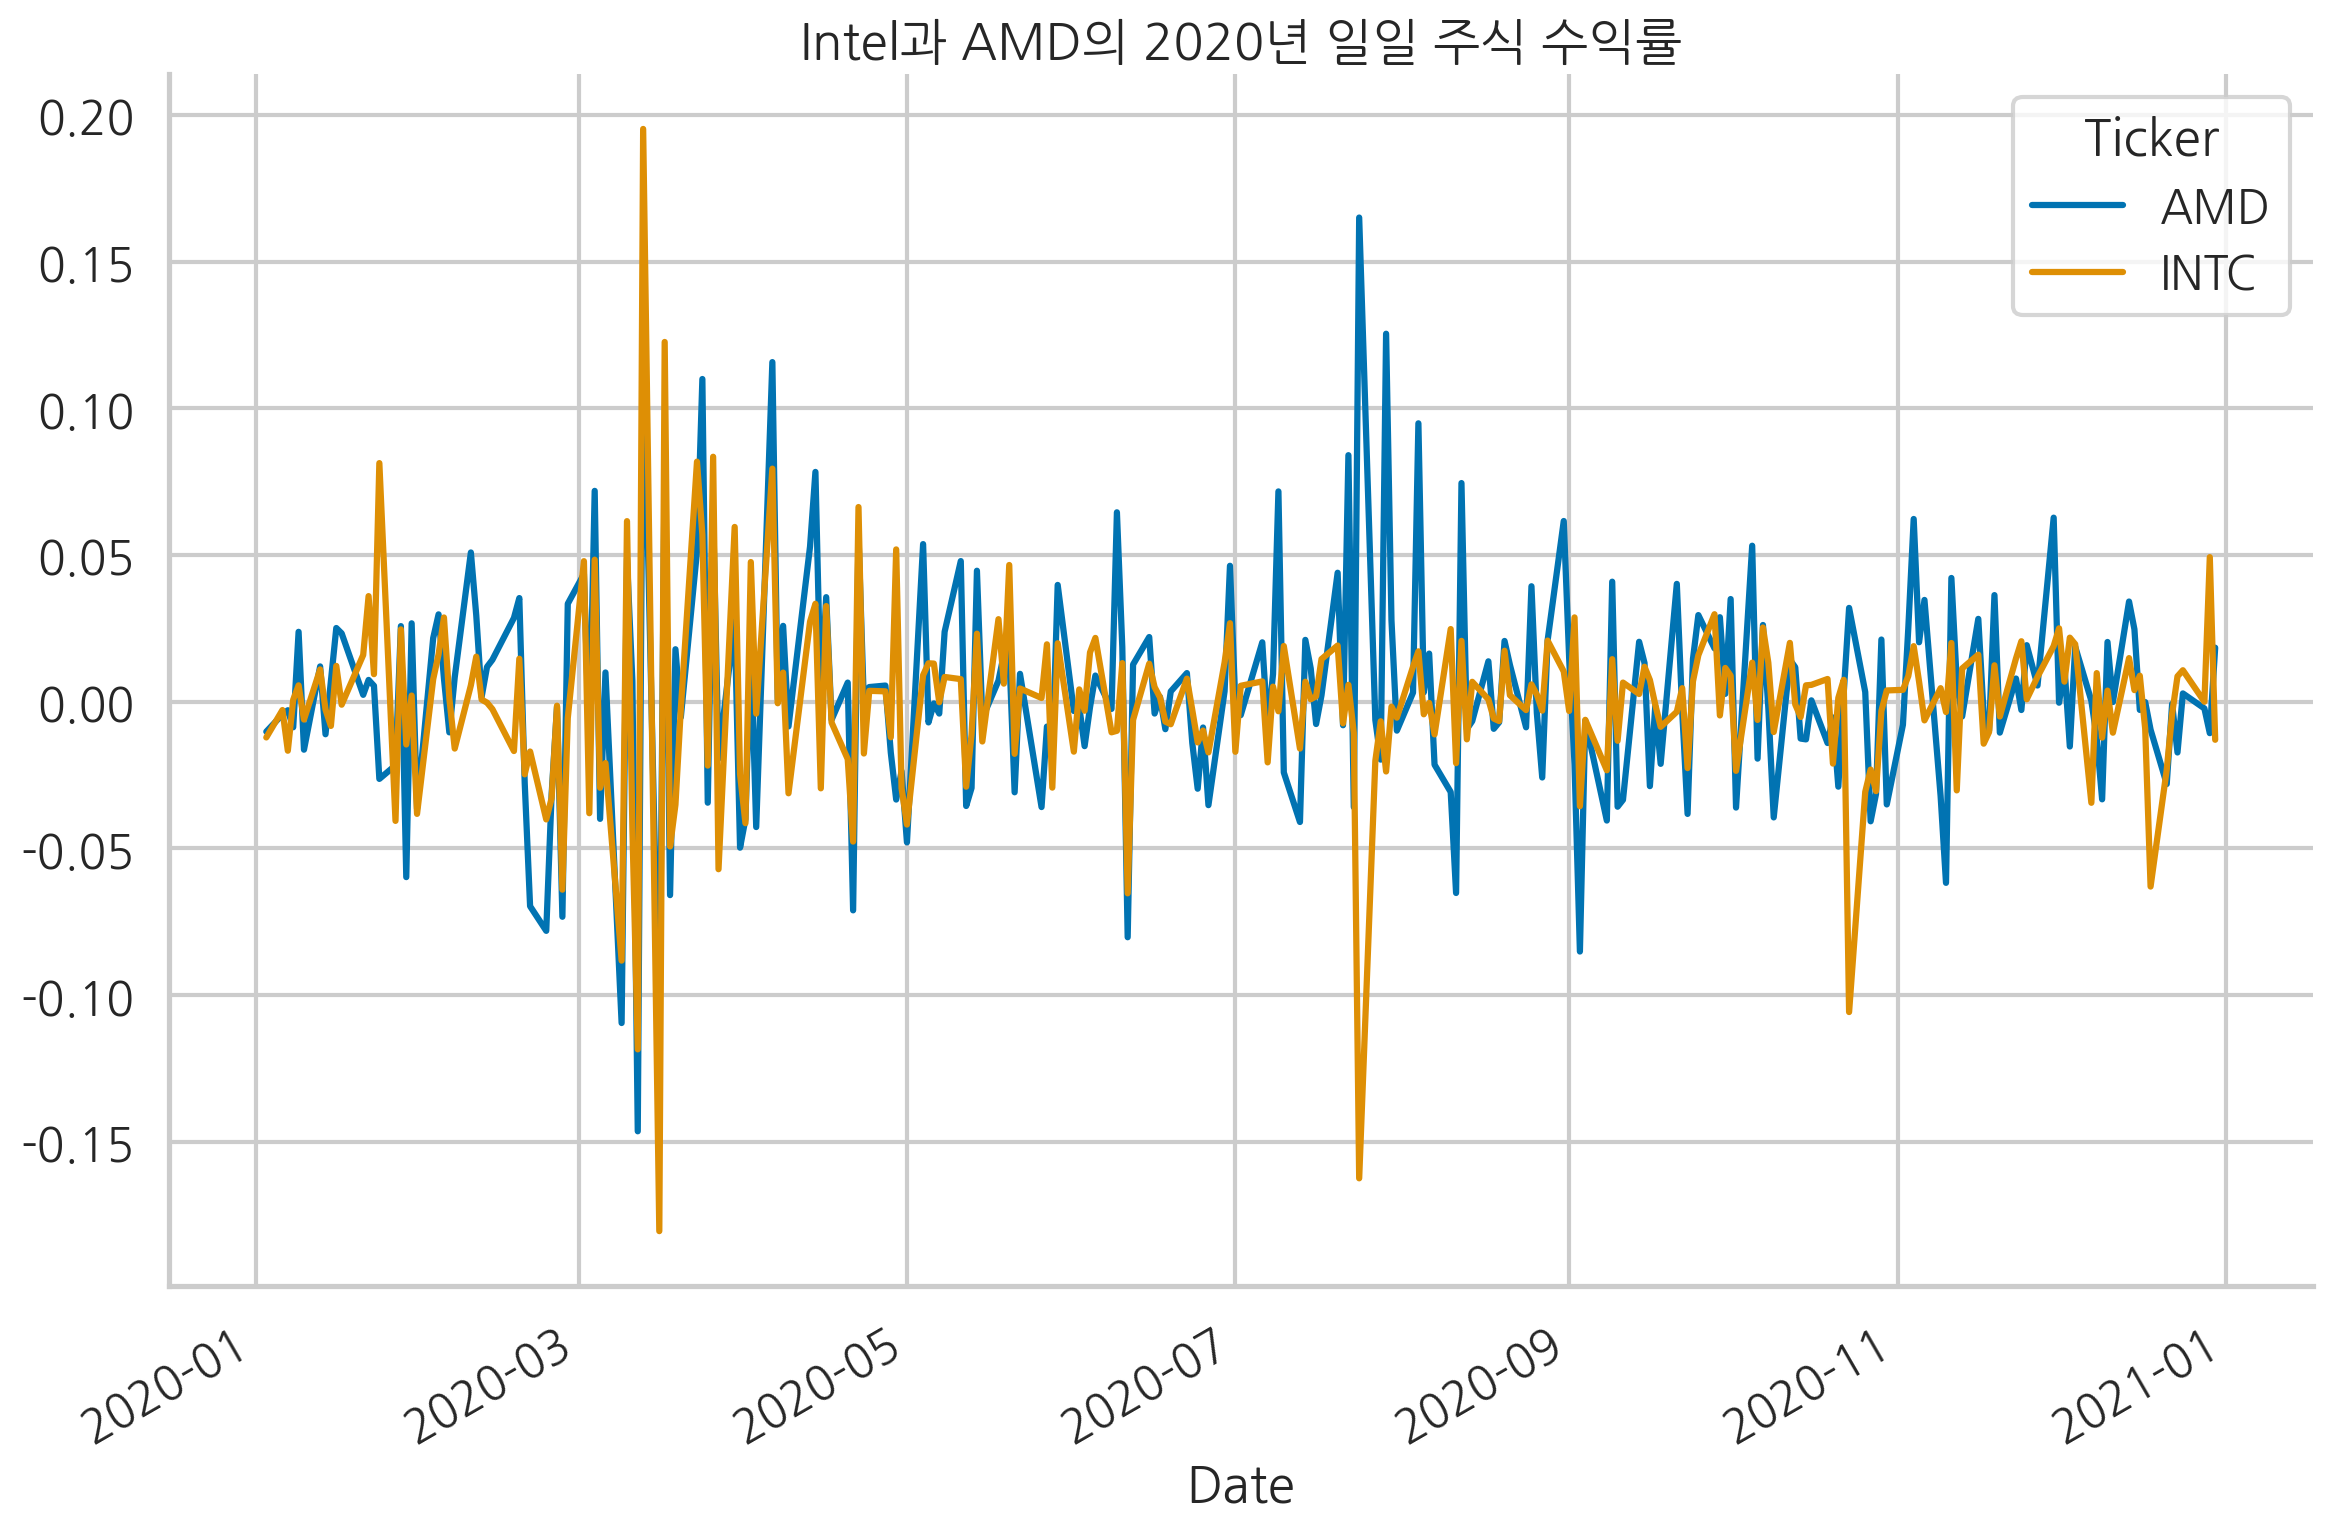

In [86]:
# 일일 수익률 계산
returns = df["Adj Close"].pct_change().dropna()

# Intel과 AMD의 2020년 일일 주식 수익률 그래프 그리기
returns.plot(title="Intel과 AMD의 2020년 일일 주식 수익률")

# 그래프에서 상단과 우측 테두리 제거
sns.despine()

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프를 이미지 파일로 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_10_3", dpi=200)

In [87]:
# Intel과 AMD 주식 수익률 간의 상관관계 계산 및 출력
# returns.corr()로 상관관계 행렬을 구하고, values[0,1]로 두 주식 간의 상관계수를 추출
# 소수점 둘째 자리까지 반올림하여 출력
print(f'수익률 간 상관관계: {returns.corr().values[0,1]:.2f}')

수익률 간 상관관계: 0.50


VaR 계산에 접근하는 두 가지 방법이 있습니다:

- **가격을 사용한 VaR 계산**: 주식 수와 자산 가격을 사용해 현재 포트폴리오의 가치와 X일 후의 가능한 가치를 계산할 수 있습니다.
- **수익률을 사용한 VaR 계산**: 포트폴리오의 각 자산에 대한 비율 가중치와 자산의 예상 수익률을 사용해 X일 후의 예상 포트폴리오 수익률을 계산할 수 있습니다. 그런 다음, VaR를 해당 수익률과 현재 포트폴리오 가치를 기반으로 달러 금액으로 표현할 수 있습니다.

자산의 가격을 결정하는 몬테카를로 접근법은 표준 정규 분포에서 추출한 무작위 변수를 사용합니다. 포트폴리오 VaR를 계산하는 경우, 우리 포트폴리오의 자산들이 상관관계가 있을 수 있다는 사실을 고려해야 합니다. 이를 위해 5단계에서 7단계까지는 상관관계가 있는 무작위 변수를 생성했습니다. 먼저 과거 공분산 행렬을 계산한 다음, 이를 콜레스키 분해를 사용하여 무작위 변수 행렬에 곱했습니다.

또 다른 상관관계가 있는 무작위 변수를 생성하는 방법으로는 콜레스키 분해 대신 단일값 분해(Singular Value Decomposition, SVD)를 사용하는 것입니다. 이를 위해 사용할 수 있는 함수는 `np.linalg.svd`입니다.

5. Calculate the covariance matrix:

In [88]:
# 수익률의 공분산 행렬 계산
cov_mat = returns.cov()

# 계산된 공분산 행렬 출력
cov_mat

Ticker,AMD,INTC
Ticker,,
AMD,0.001475,0.000652
INTC,0.000652,0.001137


6. Perform the Cholesky decomposition of the covariance matrix:

In [89]:
# 공분산 행렬의 콜레스키 분해 수행
chol_mat = np.linalg.cholesky(cov_mat)

# 계산된 콜레스키 분해 행렬 출력
chol_mat

array([[0.0384075 , 0.        ],
       [0.01697692, 0.02912551]])

7. Draw correlated random numbers from Standard Normal distribution:

In [102]:
# 표준 정규 분포에서 무작위 숫자 생성
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))

# 상관관계가 있는 무작위 변수 생성
# 콜레스키 분해 행렬을 사용하여 무작위 변수를 변환
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

8. Define metrics used for simulations:

8단계에서는 자산 수익률의 과거 평균, 이에 따른 표준 편차, 마지막으로 알려진 주가, 초기 포트폴리오 가치를 계산했습니다.

In [103]:
# 수익률의 평균 계산
r = np.mean(returns, axis=0).values

# 수익률의 표준편차 계산
sigma = np.std(returns, axis=0).values

# 마지막 거래일의 조정 종가 가져오기
S_0 = df["Adj Close"].values[-1, :]

# 초기 포트폴리오 가치 계산
P_0 = np.sum(SHARES * S_0)

9. Calculate the terminal price of the considered stocks:

9단계에서는 기하 브라운 운동 SDE에 분석 솔루션을 적용해 두 자산에 대해 1일 후 주가를 계산했습니다.

In [104]:
# 최종 주가 계산
# S_T: 최종 주가
# S_0: 초기 주가
# r: 평균 수익률
# sigma: 수익률의 표준편차
# T: 시간 간격
# correlated_rv: 상관관계가 있는 무작위 변수
S_T = S_0 * np.exp(
    (r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv
)

10. Calculate the terminal portfolio value and calculate the portfolio returns:

포트폴리오 VaR를 계산하기 위해 가능한 1일 후 포트폴리오 가치를 계산하고 그에 따른 차이(`P_T - P_0`)를 계산했습니다.

In [105]:
# 최종 포트폴리오 가치 계산
P_T = np.sum(SHARES * S_T, axis=1)

# 포트폴리오 가치 변화 계산
P_diff = P_T - P_0

11. Calculate VaR:

그런 다음 이를 오름차순으로 정렬했습니다. X% VaR는 단순히 정렬된 포트폴리오 차이 값의 (1-X) 번째 백분위수입니다.

**추가 설명**

신뢰 수준이 높아질수록 VaR(Value-at-Risk) 값이 커지는 것은 자연스러운 현상입니다. VaR는 특정 신뢰 수준에서 포트폴리오가 일정 기간 동안 발생할 수 있는 최대 손실을 나타내는 지표입니다. 신뢰 수준이 높아진다는 것은 더 극단적인 상황까지 고려한다는 의미입니다. 

예를 들어:

- **99% 신뢰 수준**: 포트폴리오가 하루 동안 99%의 확률로 0.95달러 이상의 손실을 보지 않을 것임을 의미합니다.
- **99.9% 신뢰 수준**: 포트폴리오가 하루 동안 99.9%의 확률로 1.55달러 이상의 손실을 보지 않을 것임을 의미합니다.
- **99.99% 신뢰 수준**: 포트폴리오가 하루 동안 99.99%의 확률로 2.10달러 이상의 손실을 보지 않을 것임을 의미합니다.

신뢰 수준이 높아질수록 더 많은 극단적인 손실 시나리오를 포함하게 되므로, VaR 값이 커집니다. 이는 더 높은 신뢰 수준에서 더 큰 손실을 견딜 준비가 되어 있어야 한다는 것을 의미합니다. 따라서, VaR는 포트폴리오의 위험을 평가하고 관리하는 데 중요한 역할을 합니다.

In [106]:
# P_diff를 오름차순으로 정렬
P_diff_sorted = np.sort(P_diff)

# VaR를 계산할 백분위수 설정 (99%, 99.9%, 99.99% 신뢰수준)
percentiles = [0.01, 0.1, 1.]

# 각 백분위수에 대한 VaR 계산
var = np.percentile(P_diff_sorted, percentiles)

# 각 신뢰수준에 대한 VaR 출력
for x, y in zip(percentiles, var):
    print(f"1일 VaR ({100-x}% 신뢰수준): {-y:.2f}$")

1일 VaR (99.99% 신뢰수준): 2.10$
1일 VaR (99.9% 신뢰수준): 1.55$
1일 VaR (99.0% 신뢰수준): 0.95$


12. Present the results on a graph:

은행은 자주 1일 및 10일 VaR를 계산합니다. 후자를 계산하기 위해 자산의 가치를 10일 간격으로 1일 VaR를 사용하여 시뮬레이션할 수 있습니다(이산화). 그러나 1일 VaR를 계산한 다음 제곱근 10을 곱하는 방식으로도 계산할 수 있습니다. 이는 은행이 자본 요구 사항을 낮추는 데 도움이 될 수 있습니다.

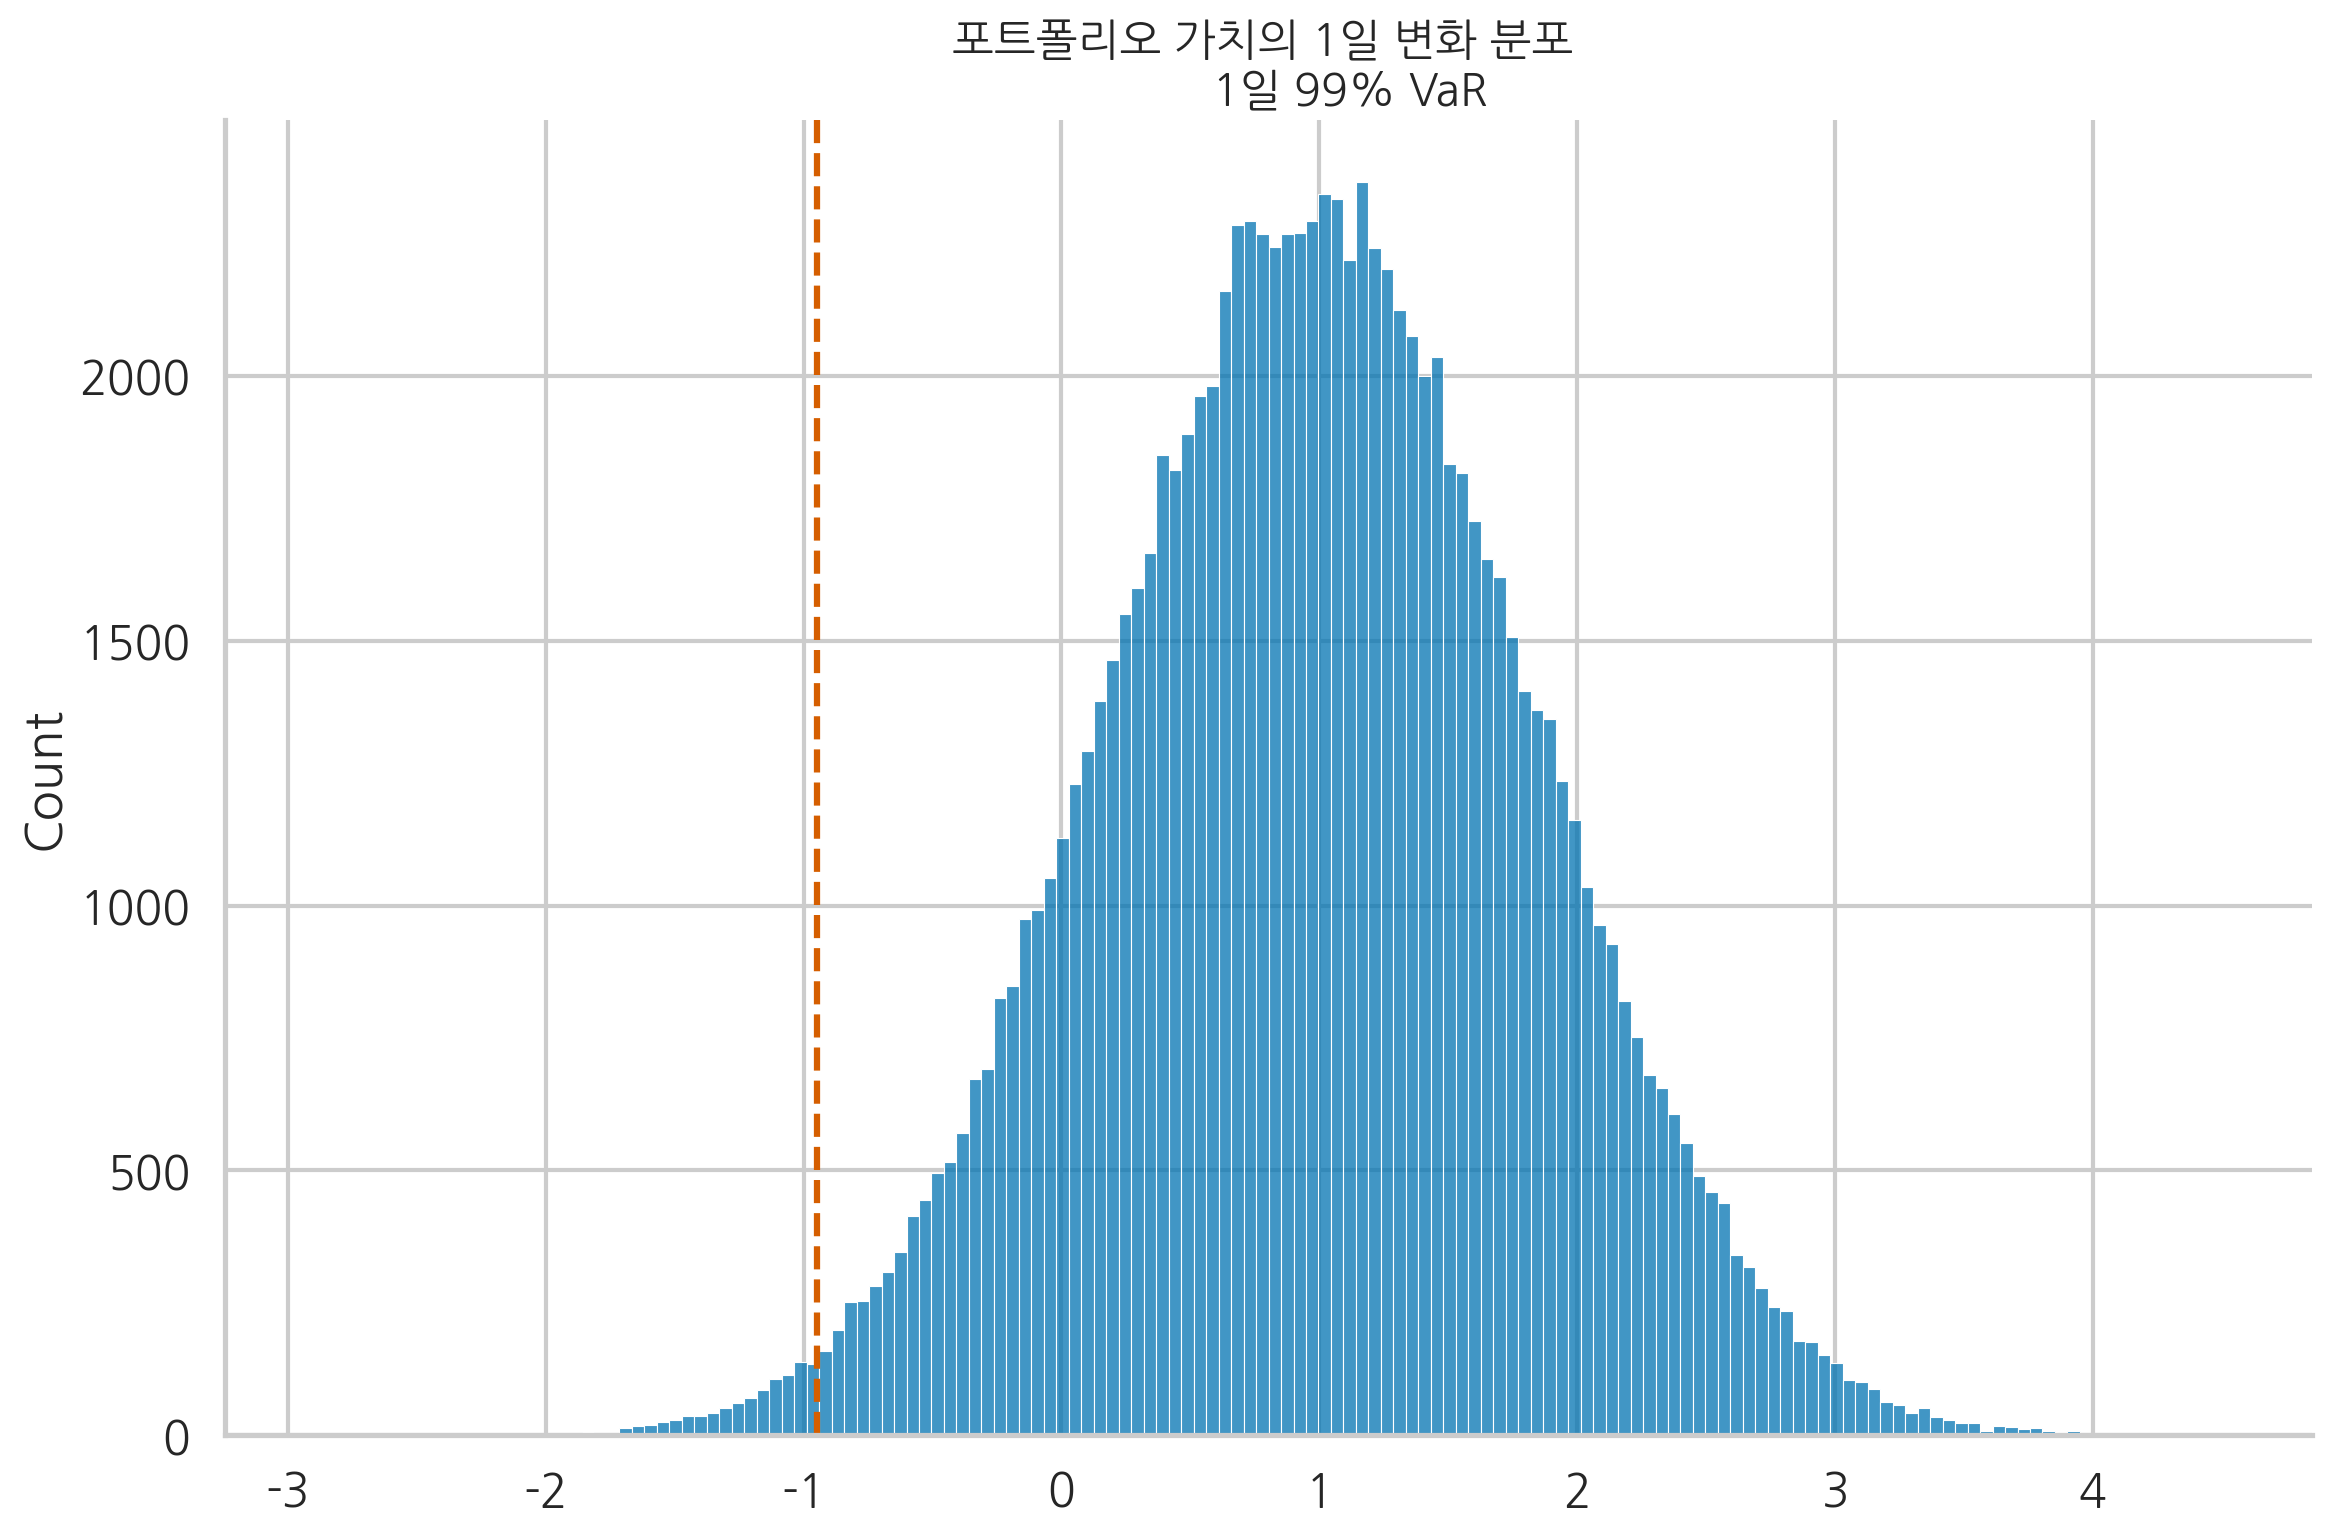

In [111]:
# P_diff의 분포를 히스토그램으로 표시
ax = sns.histplot(P_diff, kde=False)

# 그래프 제목 설정
ax.set_title("""포트폴리오 가치의 1일 변화 분포 
             1일 99% VaR""", fontsize=16)

# # 99% VaR 위치에 수직선 추가
# ax.axvline(var[2], 0, 10000)

# 99% VaR 위치에 수직선 추가
ax.axvline(var[0], color='r', linestyle='--', label='99% VaR')

# 그래프 테두리 제거
sns.despine()

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 이미지 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_10_4", dpi=200)

### There's more


앞서 언급한 것처럼 Value-at-Risk(VaR)를 계산하는 여러 가지 방법이 있으며, 각각의 방법에는 몇 가지 잠재적인 단점이 있습니다. 그중 일부는 다음과 같습니다:

- **모수 분포를 가정** (분산-공분산 접근법)
- 일일 손익이 **IID(독립적이고 동일한 분포를 가진다)** 고 가정
- **꼬리 위험** 을 충분히 포착하지 못함
- **블랙 스완** 사건을 고려하지 않음(이미 과거 데이터에 포함된 경우가 아니면)
- **역사적 VaR** 는 새로운 시장 상황에 적응하는 데 시간이 오래 걸림
- 과거 수익이 미래의 위험을 평가하기에 충분하다고 가정하는 **역사적 시뮬레이션 접근법** (이전의 포인트와 연결됨)

최근에는 VaR 추정을 위해 **딥러닝 기법** 을 사용하는 흥미로운 연구들이 있습니다. 예를 들어, **생성적 적대 신경망(GAN)** 을 사용한 방법이 있습니다.

VaR의 또 다른 일반적인 단점은 VaR가 제공하는 임계값을 초과할 때 잠재적 손실의 크기에 대한 정보를 제공하지 않는다는 점입니다. 이때 **기대 초과 손실(Expected Shortfall)** (조건부 VaR 또는 예상 꼬리 손실이라고도 불림)이 중요한 역할을 합니다. 이는 최악의 X% 시나리오에서 예상되는 손실이 얼마나 큰지를 단순히 나타냅니다.

기대 초과 손실을 계산하는 여러 가지 방법이 있지만, 여기서는 VaR와 쉽게 연결되며 몬테카를로 시뮬레이션을 사용하여 추정할 수 있는 방법을 설명합니다.

두 자산으로 구성된 포트폴리오의 예를 계속해서 설명하면, 우리는 다음과 같은 질문을 할 수 있습니다: **VaR를 초과하는 손실이 발생할 경우 그 손실은 얼마나 클까?** 이 숫자를 구하려면 VaR보다 큰 모든 손실을 필터링한 후, 그 값의 평균을 구해야 합니다.

다음 코드를 사용하여 이를 수행할 수 있습니다:

In [108]:
# 5% 백분위수를 계산하여 95% VaR 구하기
var = np.percentile(P_diff_sorted, 5)

# VaR보다 작거나 같은 값들의 평균을 계산하여 기대 초과 손실 구하기
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

# 1일 95% VaR와 기대 초과 손실 출력
print(f'1일 95% VaR는 {-var:.2f}$이며, 이에 상응하는 기대 초과 손실은 {-expected_shortfall:.2f}$입니다.')

1일 95% VaR는 0.38$이며, 이에 상응하는 기대 초과 손실은 0.73$입니다.


기대 초과 손실을 계산할 때는 VaR 선 왼쪽의 모든 시뮬레이션 중 작은 부분만 사용한다는 점을 염두에 두어야 합니다. 따라서 기대 초과 손실의 합리적인 결과를 얻으려면 전체 표본이 충분히 커야 합니다.

1일 95% VaR는 $0.29이며, 이에 상응하는 기대 초과 손실은 $0.64입니다. 이를 다음과 같이 해석할 수 있습니다: 손실이 95% VaR를 초과할 경우, 1일 동안 포트폴리오를 보유하면 $0.64의 손실을 볼 가능성이 있습니다.

## Summary

이 장에서는 몬테카를로 시뮬레이션을 다루었으며, 이는 많은 금융 작업에서 매우 유용한 도구입니다. 우리는 기하 브라운 운동을 사용하여 주가를 시뮬레이션하고, 다양한 유형의 옵션(유럽형, 미국형, 배리어)의 가격을 책정하며, Value-at-Risk를 계산하는 방법을 시연했습니다.

하지만 이 장에서는 몬테카를로 시뮬레이션의 모든 가능한 응용 분야를 거의 다루지 못했습니다. 다음 장에서는 자산 배분을 위한 효율적 경계(efficient frontier)를 얻기 위해 몬테카를로 시뮬레이션을 사용하는 방법도 설명할 것입니다.